In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import itertools
import pickle

from matplotlib import rcParams
from scipy.optimize import curve_fit, root_scalar
from scipy.signal import savgol_filter


In [4]:
rcParams['figure.figsize'] = 12, 5
plt.rcParams.update({'font.size': 15})
plotsize = (10, 6)
legend_size = 12
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

# 1. Import and Plot Spectroscopy Data

### 1.1 Define Functions

In [5]:
def get_data(filename, measurement='amp'):
    data1 = loadmat(filename)
    transAmpData1 = data1['transamp']
    specAmpData1 = data1['specamp']
    specPhaseData1 = data1['specphase']
    specFreqVector1 = data1['specfreq']
    volts1 = data1['voltage_vector']

    Ylist = specFreqVector1
    Xlist0 = volts1
    Xlist = Xlist0

    Xlist = np.asarray(Xlist)
    Ylist = np.asarray(Ylist)*1e-9

    # Xlist = (Xlist - voltOffSet +VoltPerFlux*center)/VoltPerFlux

    X,Y = np.meshgrid(Xlist,Ylist)

    ### make copies of spec data 
    phase = specPhaseData1.copy()
    amp = specAmpData1.copy()

    ### remove average for better plotting
    for i in range(0, len(phase[:,1]) ):
        phase[i,:] = phase[i,:] - np.mean(phase[i,:])
        amp[i,:] = amp[i,:] - np.mean(amp[i,:])
    
    if measurement == 'amp':
        Z = amp.copy()
    elif measurement == 'phase':
        Z = phase.copy()
    Z = np.asarray(Z)
    Z = np.transpose(Z)
    
    return(X, Y, Z)

In [6]:
def plot_spec_data(voltage_data, frequency_data, transmission_data, qubit_name=None, fit_voltages=None, fit_frequencies=None, vmin=-2, vmax=10):
    

    # Initialize the plot
    plt.figure()


    # To store axis limits
    voltage_min_all = float('inf')
    voltage_max_all = float('-inf')
    frequency_min_all = float('inf')
    frequency_max_all = float('-inf')

    for i in range(len(transmission_data)):
        voltage_min = voltage_data[i][0, 0]
        voltage_max = voltage_data[i][0, -1]
        voltage_step = voltage_data[i][0, 1] - voltage_data[i][0, 0]

        frequency_min = frequency_data[i][0, 0]
        frequency_max = frequency_data[i][-1, 0]
        frequency_step = frequency_data[i][1, 0] - frequency_data[i][0, 0]

        extent = (voltage_min - voltage_step / 2, 
                  voltage_max + voltage_step / 2, 
                  frequency_min - frequency_step / 2, 
                  frequency_max + frequency_step / 2)

        plt.imshow(transmission_data[i], interpolation='none', vmin=vmin, vmax=vmax, origin='lower', cmap='summer', aspect='auto', extent=extent, alpha=0.7)


        # Update the overall min/max for voltage and frequency
        voltage_min_all = min(voltage_min_all, extent[0])
        voltage_max_all = max(voltage_max_all, extent[1])
        frequency_min_all = min(frequency_min_all, extent[2])
        frequency_max_all = max(frequency_max_all, extent[3])

    # Set the overall axis limits
    plt.xlim(voltage_min_all, voltage_max_all)
    plt.ylim(frequency_min_all, frequency_max_all)

    if fit_frequencies is not None and fit_voltages is not None:
        plt.plot(fit_voltages, fit_frequencies, marker='o',linestyle='', color='red', ms=2)
        
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (MHz)')
    plt.colorbar(label='Transmission (a.u.)')
    
    title = 'Qubit frequency vs voltage'
    if qubit_name is not None:
        title = f'{qubit_name} frequency vs voltage'
    plt.title(title)
    plt.show()


In [7]:
def generate_filename(datecode, timecode, file_name_start=None):
    if file_name_start is None:
        file_name_start = '2Tone8Qubit_Tri'
    return r'V:\QSimMeasurements\Measurements\8QV1_Triangle_Lattice\pnax{}25\{}_2025{}_{}'.format(datecode, file_name_start, datecode, timecode)

### 1.2 Plot Spec Data

In [8]:
generate_filename('0609', '1500')

'V:\\QSimMeasurements\\Measurements\\8QV1_Triangle_Lattice\\pnax060925\\2Tone8Qubit_Tri_20250609_1500'

In [16]:
all_qubits = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

filenames_Q1 = [generate_filename('0609', '1500'),
                generate_filename('0610', '0002')]

filenames_Q2 = [generate_filename('0609', '1527'),
                generate_filename('0610', '0038')]

filenames_Q3 = [generate_filename('0609', '1552'),
                generate_filename('0610', '0934')]

filenames_Q4 = [generate_filename('0609', '1633'),
                generate_filename('0610', '1008')]

filenames_Q5 = [generate_filename('0609', '1719'),
                generate_filename('0610', '1205')]

filenames_Q6 = [generate_filename('0609', '1940'),
                generate_filename('0610', '1241')]

filenames_Q7 = [generate_filename('0609', '2013'),
                generate_filename('0610', '1317')]

filenames_Q8 = [generate_filename('0609', '2127'),
                generate_filename('0610', '1408')]

qubit_to_spec_filenames = {'Q1': filenames_Q1,
                           'Q2': filenames_Q2,
                           'Q3': filenames_Q3,
                           'Q4': filenames_Q4,
                           'Q5': filenames_Q5,
                           'Q6': filenames_Q6,
                           'Q7': filenames_Q7,
                           'Q8': filenames_Q8
                        }


qubit_to_voltage_data_all = {}
qubit_to_frequency_data_all = {}
qubit_to_transmission_data_all = {}




for qubit in all_qubits:
    
    voltage_data_all = []
    frequency_data_all = []
    transmission_data_all = []
    
    for file in qubit_to_spec_filenames[qubit]:
        
        X, Y, Z = get_data(file)
            
        voltage_data_all.append(X)
        frequency_data_all.append(Y)
        transmission_data_all.append(Z)
        
    qubit_to_voltage_data_all[qubit] = voltage_data_all
    qubit_to_frequency_data_all[qubit] = frequency_data_all    
    qubit_to_transmission_data_all[qubit] = transmission_data_all    

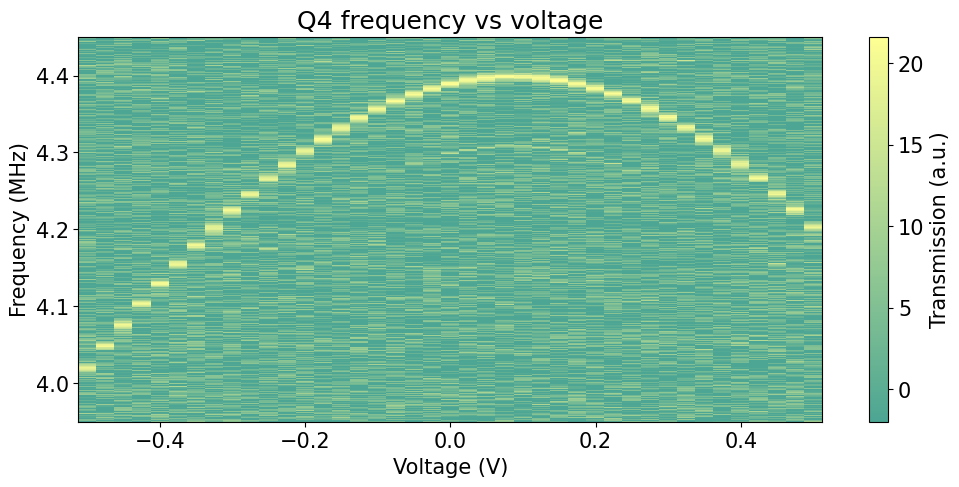

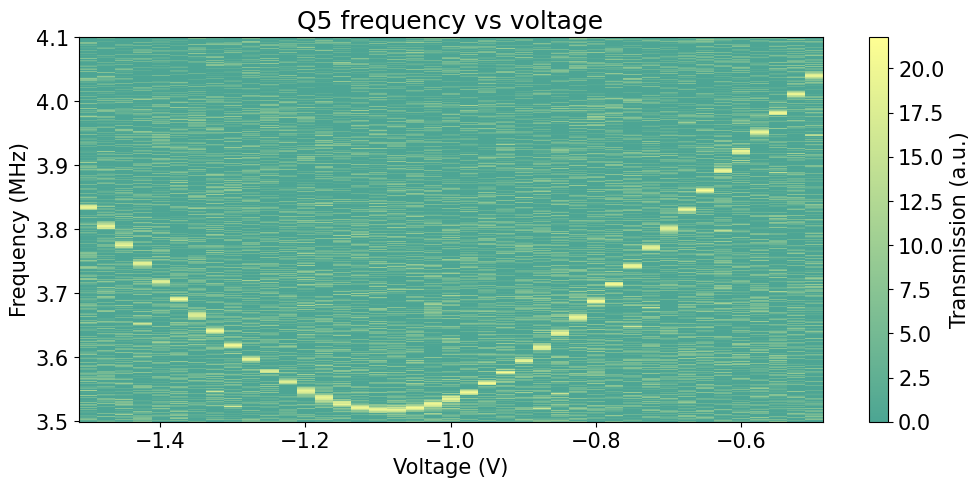

In [ ]:

file = generate_filename('0609', '1500')

voltage_data_all, frequency_data_all, transmission_data_all = get_data(file)
            

plot_spec_data([voltage_data_all], [frequency_data_all], [transmission_data_all], qubit_name='Q4', vmin=-2, vmax=None)



file = generate_filename('0610', '0002')

voltage_data_all, frequency_data_all, transmission_data_all = get_data(file)
            

plot_spec_data([voltage_data_all], [frequency_data_all], [transmission_data_all], qubit_name='Q5', vmin=0, vmax=None)

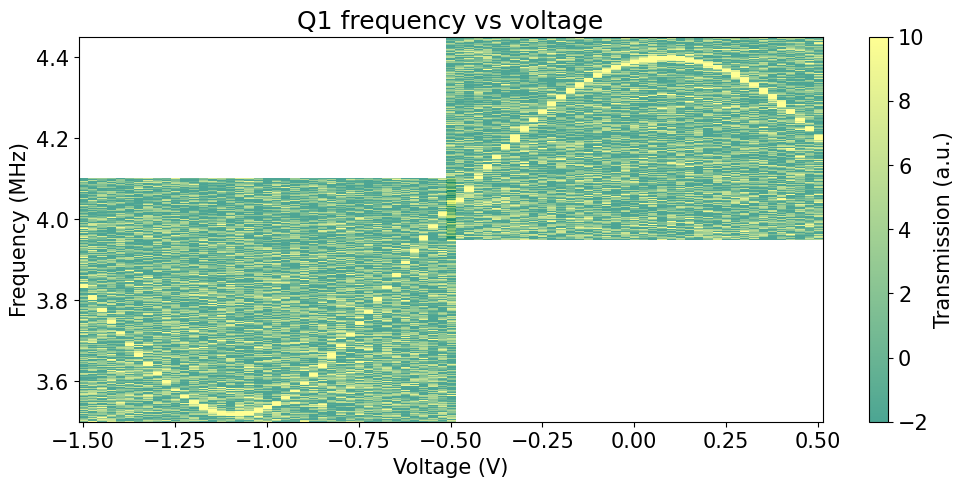

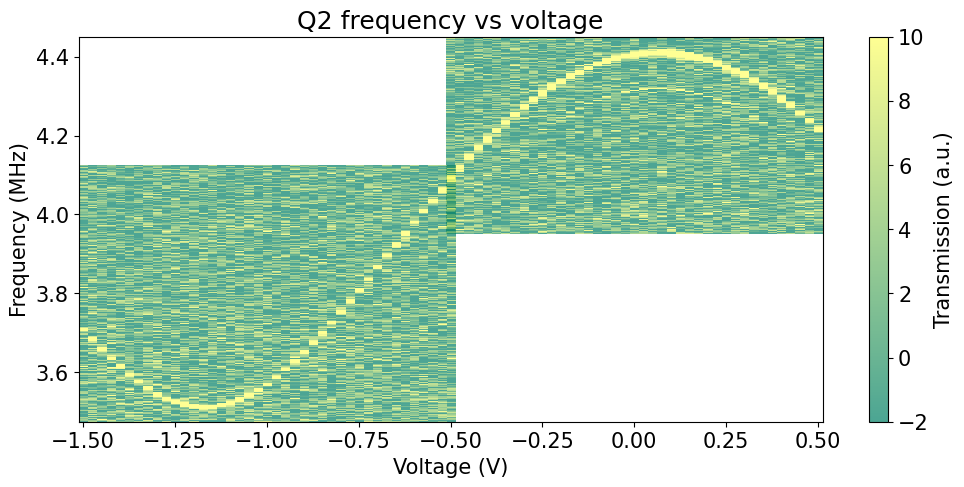

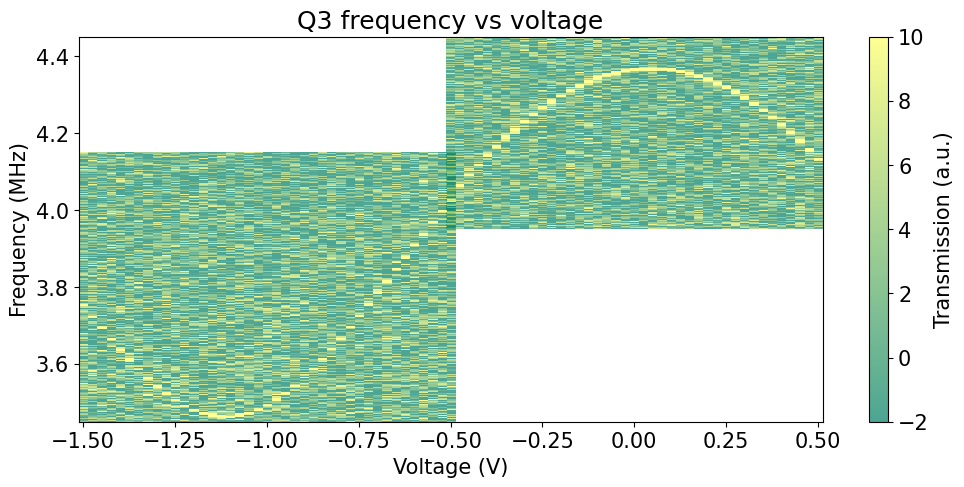

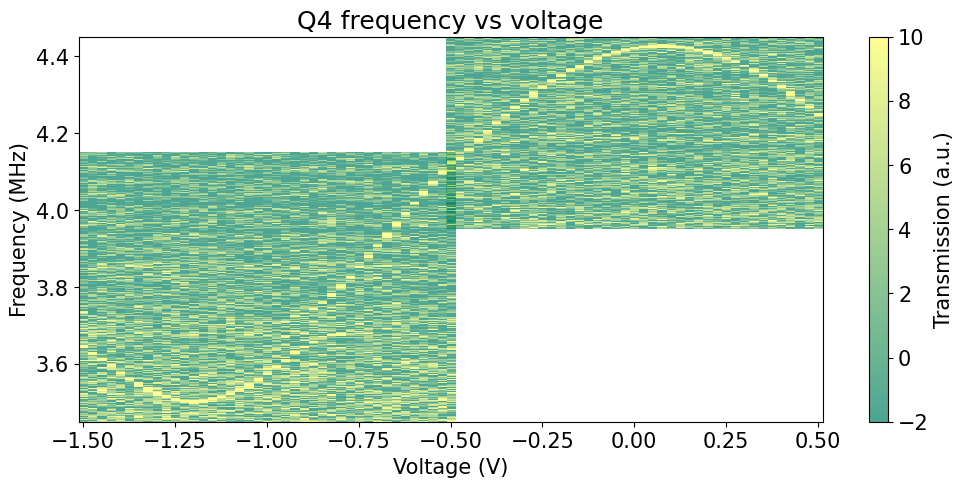

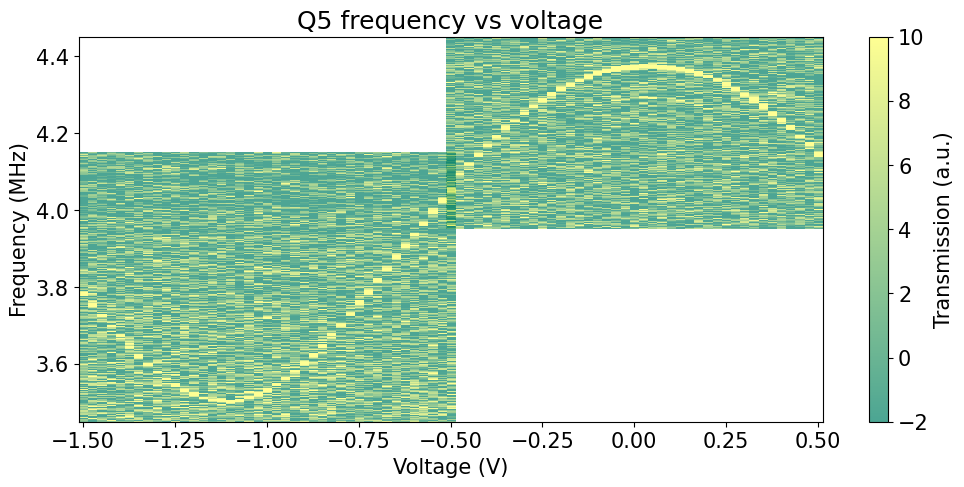

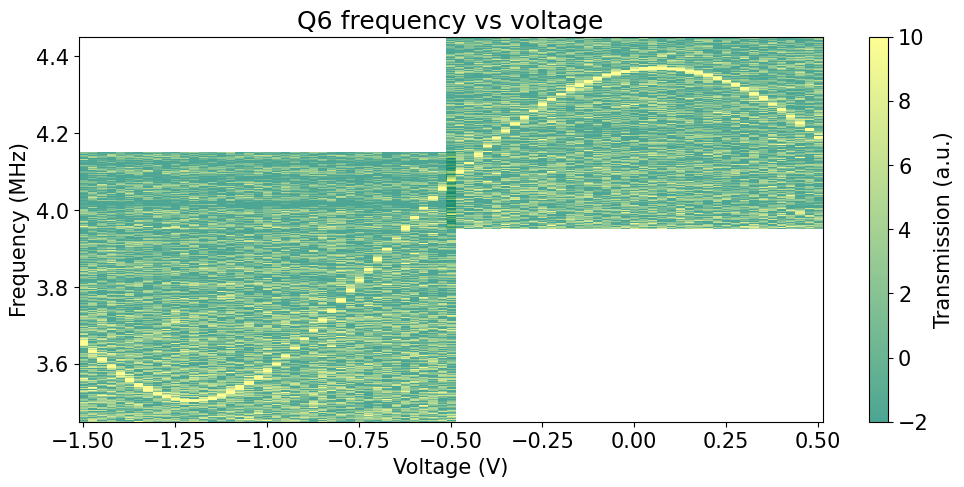

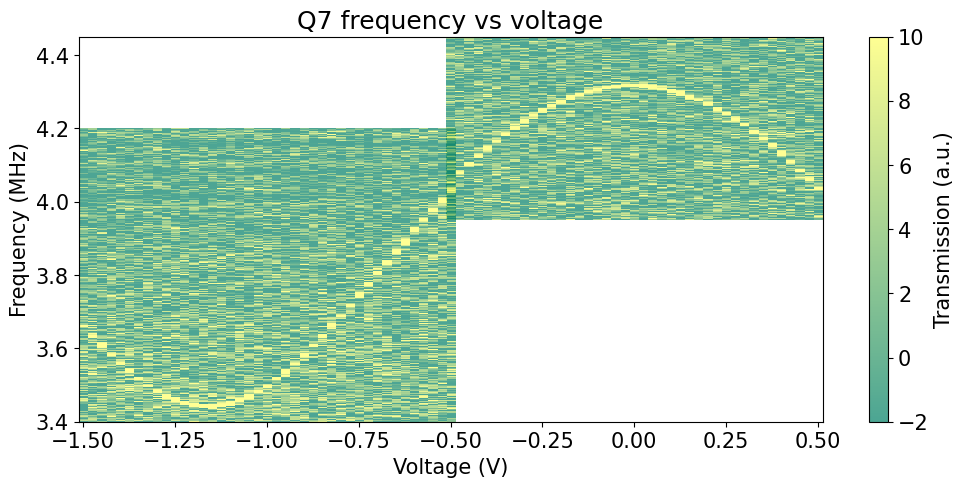

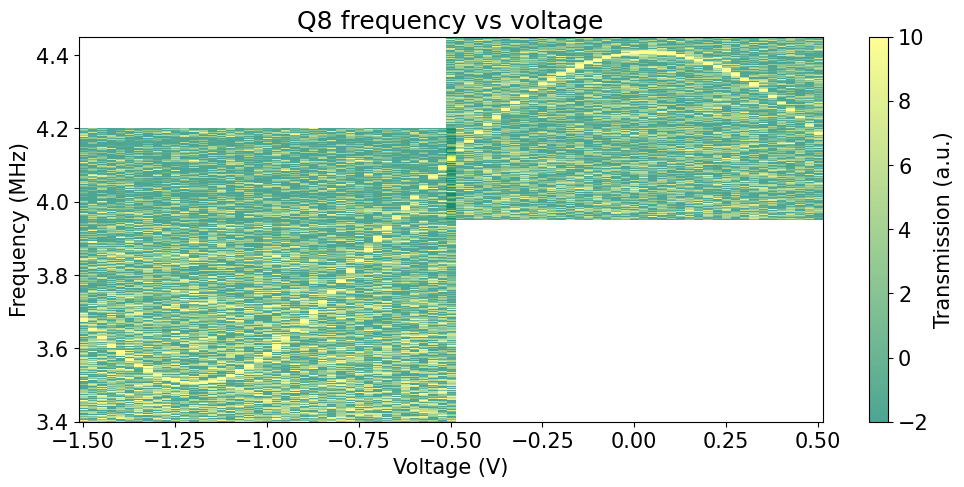

In [17]:
plot_qubits = all_qubits
# plot_qubits = ['Q1', 'Q2']


for qubit in plot_qubits:
    voltage_data_all = qubit_to_voltage_data_all[qubit]
    frequency_data_all = qubit_to_frequency_data_all[qubit]
    transmission_data_all = qubit_to_transmission_data_all[qubit]
    
    if len(voltage_data_all) > 0:
        plot_spec_data(voltage_data_all, frequency_data_all, transmission_data_all, qubit_name=qubit)


# 2. Find Peaks

### 2.1 Fit to Lorentzian

In [18]:
def lorentzian_fit(x, x0, a, b, c):
    return a/(b+np.power((x-x0), 2))+c

In [19]:
def get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index=5, frequency_index_span=100, plot_fits=False):
    '''
    :param frequency_index_span: number of points around peak to try fit
    '''
    
#     center_frequencies = np.zeros(voltage_data.shape[1])
#     center_frequency_errors = np.zeros(voltage_data.shape[0])
    center_frequencies = []
    center_frequency_errors = []
    voltage_points_with_fit = []
    
    voltages = voltage_data[0,:]
    
    if isinstance(start_index, int):
        start_indices = [start_index] * len(voltages)
    else:
        start_indices = list(start_index)
    
    for i in range(len(voltages)):
        
#         print(f'index: {i}')
        
        frequencies = frequency_data[:,0]
        # find peak
        if i >= len(start_indices):
            start_index = start_indices[-1]
        else:
            start_index = start_indices[i]
        row = transmission_data[start_index:,i]
        
        peak_index = np.argmax(row) + start_index
        center_frequency_guess = frequencies[peak_index]
        
        
        # fit to lorentzian
        # restrict fit in range span around peak

        restricted_frequencies = frequencies[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies))]
        restricted_row = transmission_data[max(peak_index - frequency_index_span//2, 0):min(peak_index + frequency_index_span//2, len(frequencies)),i]
        
        # apply savgol filter
        
        filtered_row = savgol_filter(restricted_row, 7, 1)
        
        bounds = ([restricted_frequencies[0], 0, 0, -np.inf], [restricted_frequencies[-1], np.inf, np.inf, np.inf])
        initial_guess = [center_frequency_guess, 0.001, 0.0001, 0]
        try:
            popt, pcov = curve_fit(lorentzian_fit, restricted_frequencies, filtered_row, p0=initial_guess, bounds=bounds)
        except:
            # if it fails, plot the data it was trying to fit
            plt.plot(restricted_frequencies, filtered_row, linestyle='', marker='o', label='data')
            plt.plot(restricted_frequencies, lorentzian_fit(restricted_frequencies, *initial_guess), label='guess')
            plt.xlabel('Frequency (MHz)')
            plt.title(f'Lorentzian fit for index {i}')
            plt.axvline(center_frequency_guess, color='red')
            plt.legend()
            plt.show()
            
            print('Couldn\'t get a fit')
            
            # use max as the center frequency
            center_frequencies.append(restricted_frequencies[np.argmax(filtered_row)])
            voltage_points_with_fit.append(voltages[i])
            center_frequency_errors.append(frequencies[-1] - frequencies[0])
            
            
        else:
            
            center_frequencies.append(popt[0])

            perr = np.sqrt(np.diag(pcov))
            center_frequency_errors.append(perr[0])

            voltage_points_with_fit.append(voltages[i])
            
            if plot_fits:
                plt.plot(frequencies[start_index:], row, linestyle='', marker='o', label='data')

                fit_frequencies = np.linspace(frequencies[start_index], frequencies[-1], 1000)
                plt.plot(fit_frequencies, lorentzian_fit(fit_frequencies, *popt), label='fit')
                plt.axvline(center_frequency_guess, color='red')
                plt.legend()

                plt.xlabel('Frequency (MHz)')
                plt.title(f'Lorentzian fit for index {i}')
                plt.show()

                print(f'Center frequency is {popt[0]} MHz')
            
    return voltage_points_with_fit, center_frequencies, center_frequency_errors


In [20]:
qubit_to_voltages = {}
qubit_to_frequencies = {}

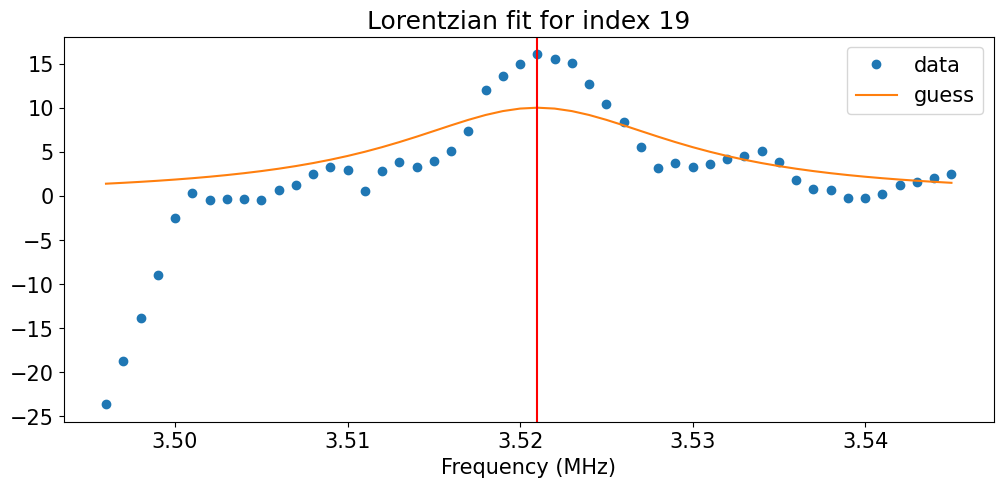

Couldn't get a fit


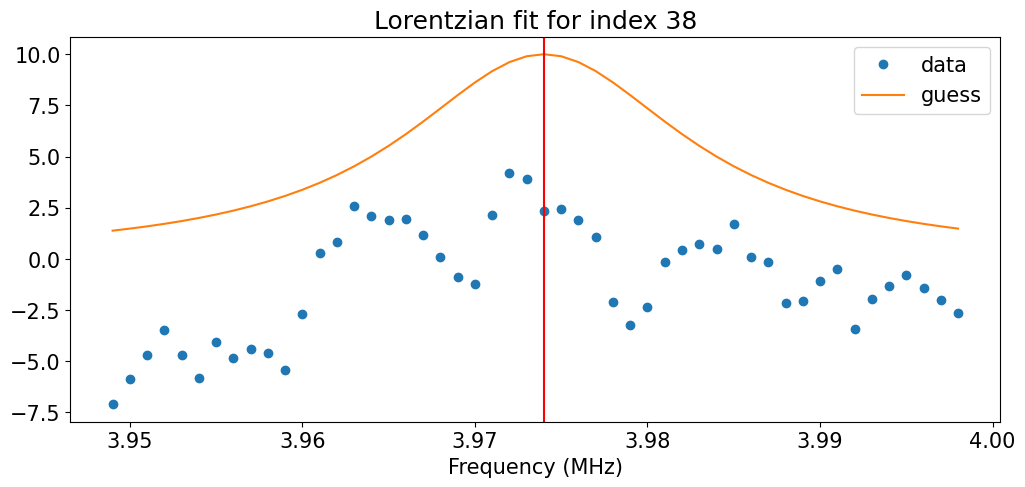

Couldn't get a fit


In [23]:
# rescan_qubits = ['Q1', 'Q2']
rescan_qubits = all_qubits

for qubit in rescan_qubits:
    voltages = []
    center_frequencies = []
    center_frequency_errors = []

    plot_fits = False
    plot_as_flux=True
    plot_as_flux=False

    for file in qubit_to_spec_filenames[qubit]:
        
        voltage_data, frequency_data, transmission_data = get_data(file)
        start_index = 5

        frequency_index_span = 50
#         if qubit == 'Q4':
#             frequency_index_span = 50
#             start_index = [100]*200 + [300]*200 + [500]*200 + [600]*200 + [600]*200


        file_voltages, file_frequencies, error = get_center_frequencies(voltage_data, frequency_data, transmission_data, start_index, frequency_index_span=frequency_index_span, plot_fits=plot_fits)

        voltages.extend(file_voltages)
        center_frequencies.extend(file_frequencies)
        center_frequency_errors.extend(error)

    voltages = np.array(voltages)
    center_frequencies = np.array(center_frequencies)
    center_frequency_errors = np.array(center_frequency_errors)

    plt.show()

    # sort data by voltage

    sorted_indices = voltages.argsort()
    voltages = voltages[sorted_indices]
    center_frequencies = center_frequencies[sorted_indices]
    center_frequency_errors = center_frequency_errors[sorted_indices]
    
    qubit_to_voltages[qubit] = voltages
    qubit_to_frequencies[qubit] = center_frequencies


### 2.2 Plot Results

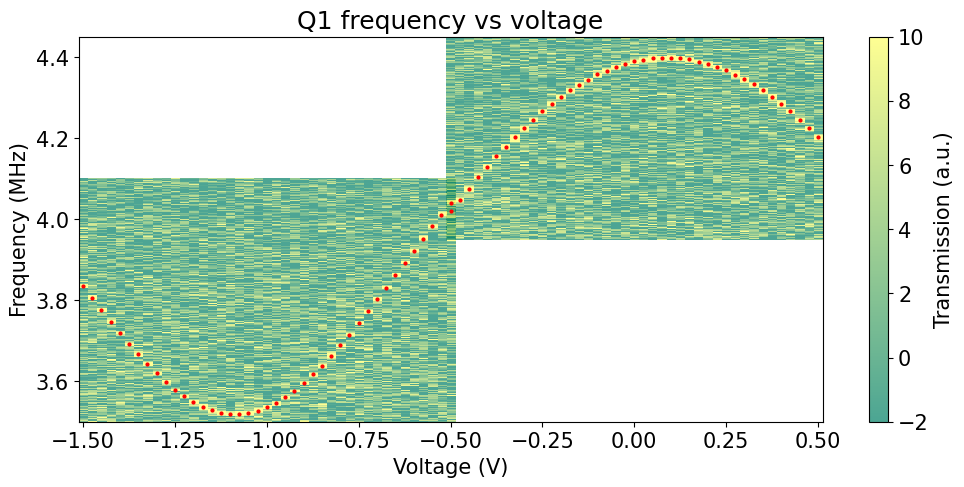

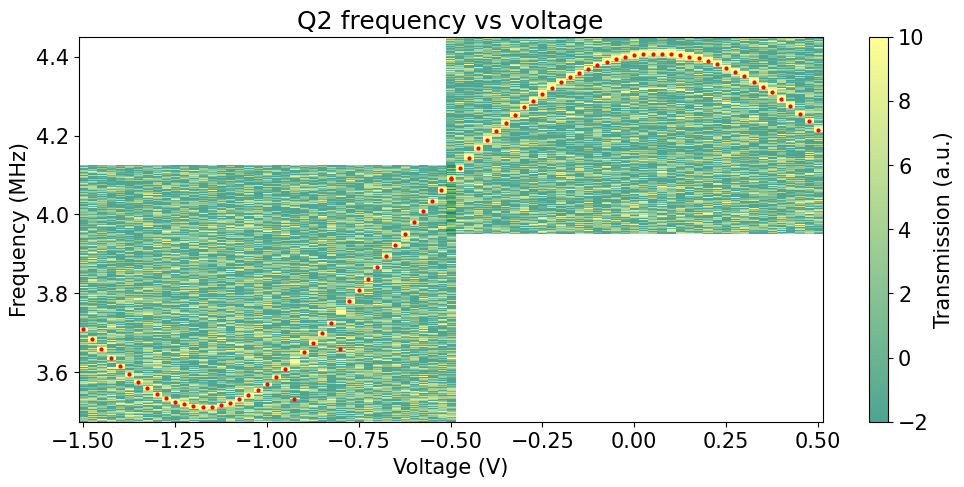

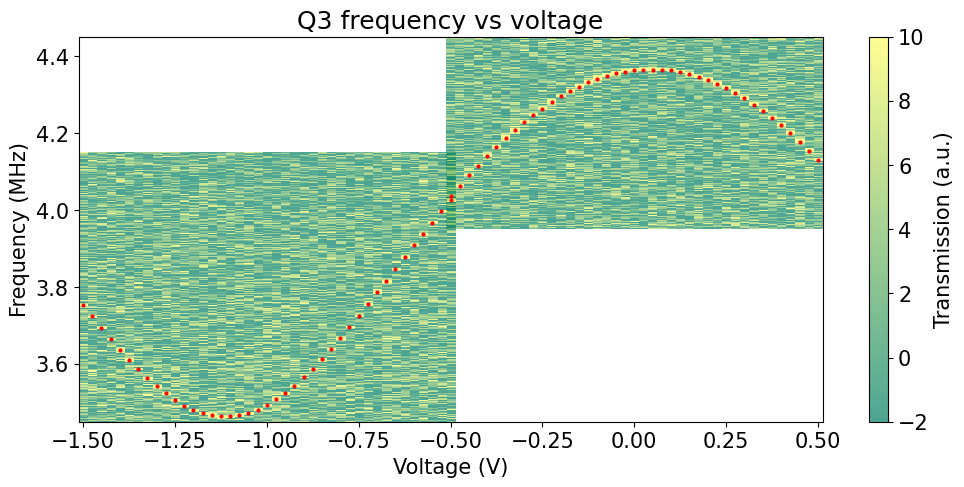

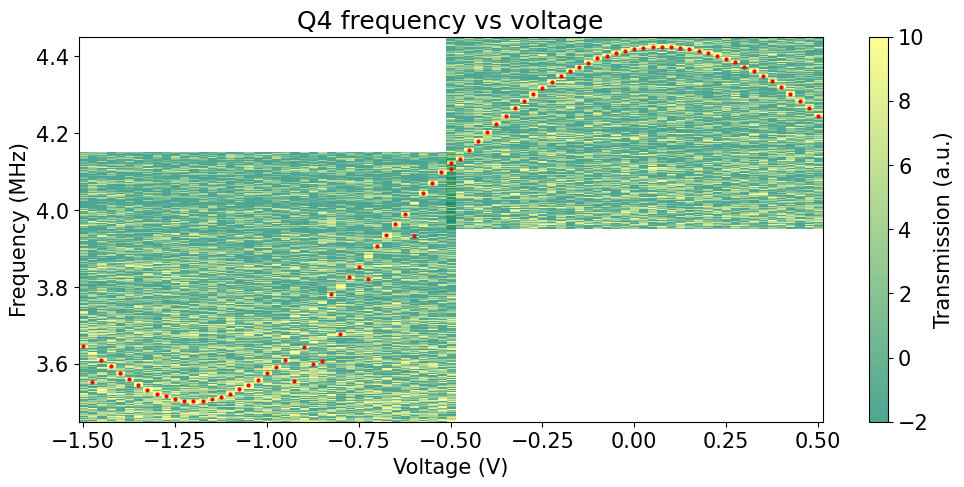

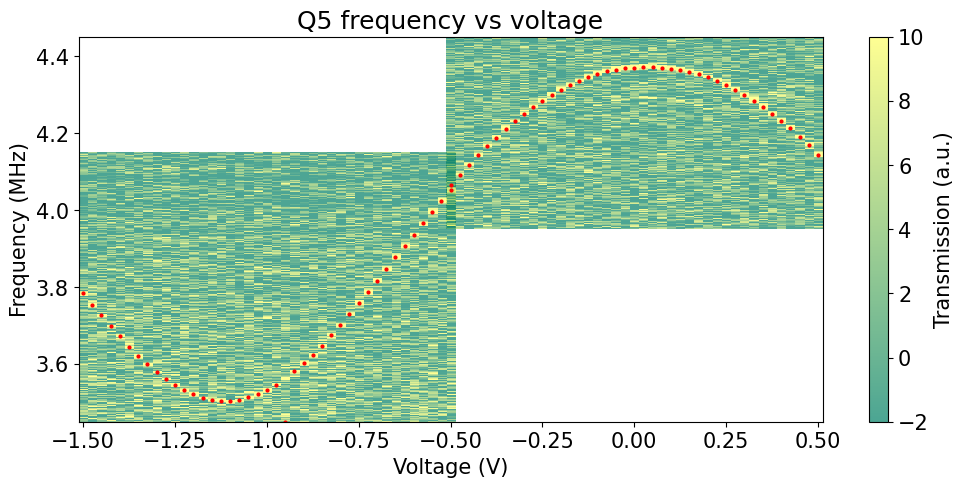

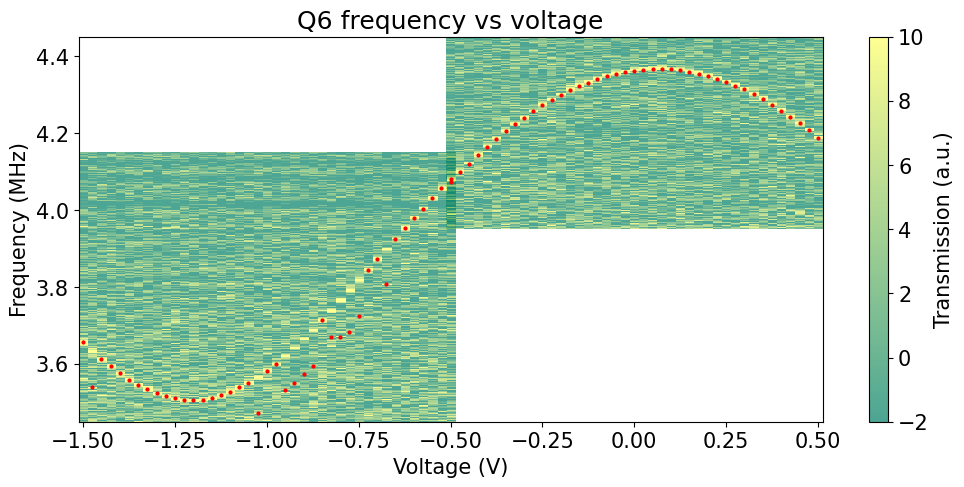

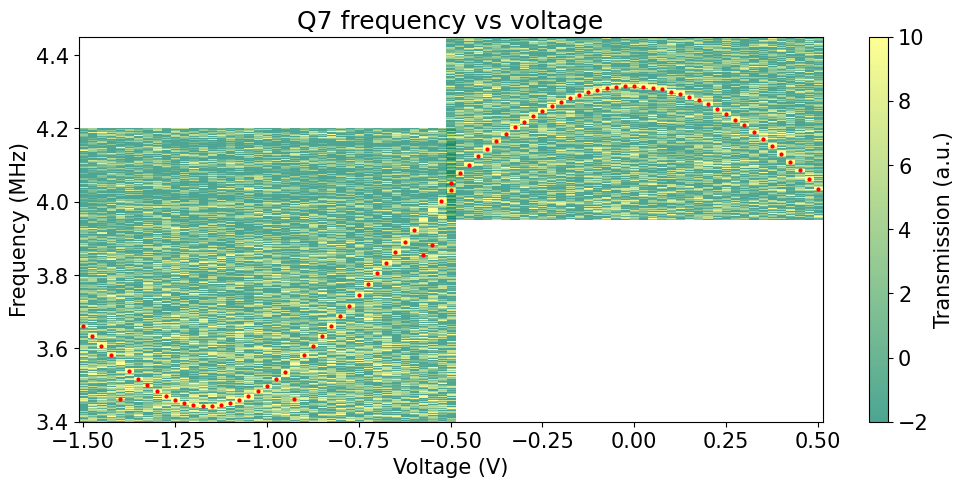

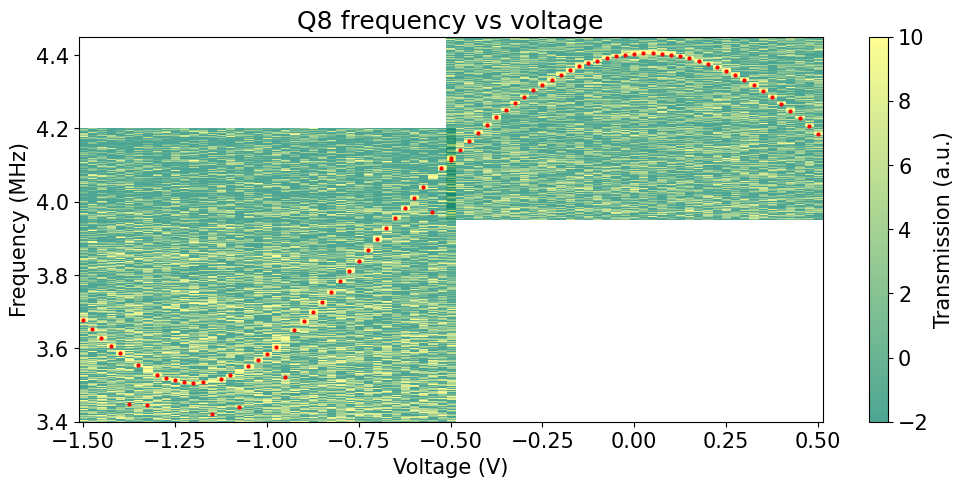

In [24]:
### plot spec data with center frequencies
for qubit in all_qubits:
    voltage_data_all = qubit_to_voltage_data_all[qubit]
    frequency_data_all = qubit_to_frequency_data_all[qubit]
    transmission_data_all = qubit_to_transmission_data_all[qubit]
    
    if len(voltage_data_all) > 0:

        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]

        plot_spec_data(voltage_data_all, frequency_data_all, transmission_data_all, fit_voltages=voltages, fit_frequencies=frequencies, qubit_name=qubit)


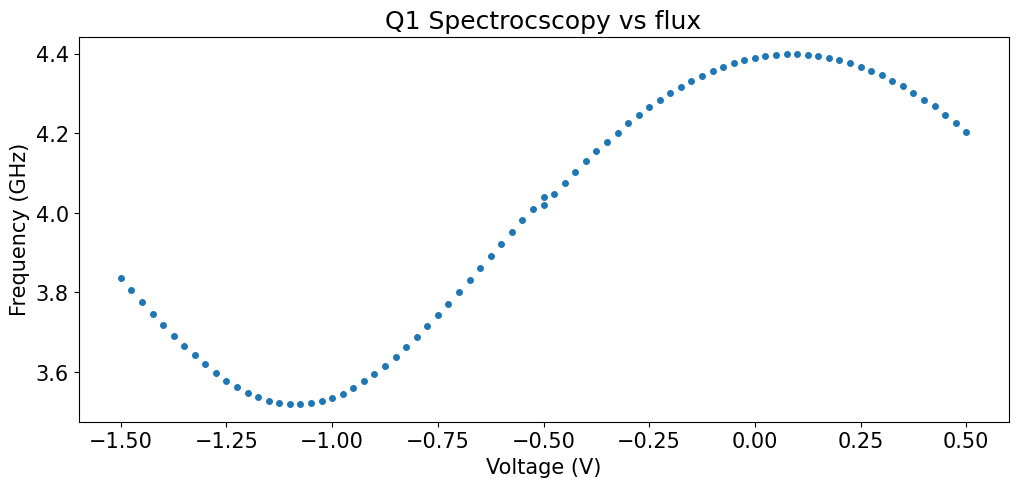

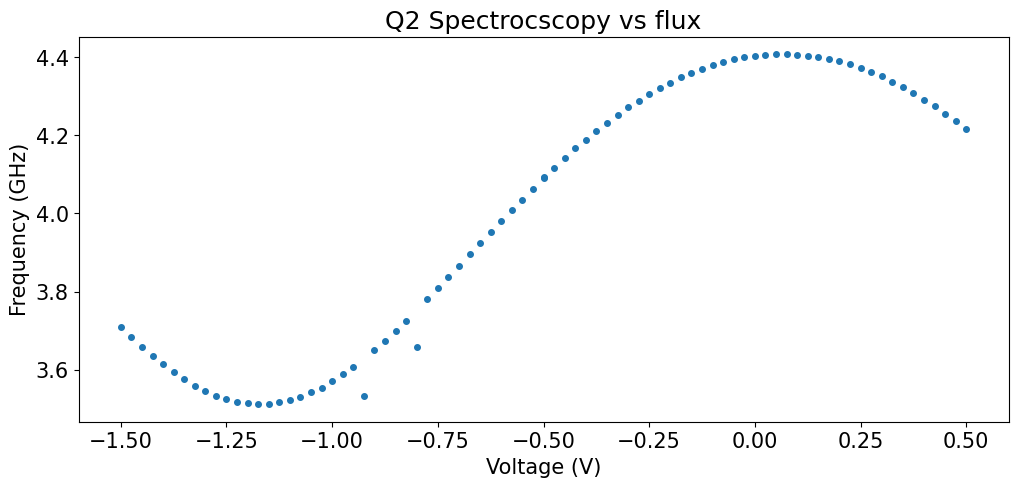

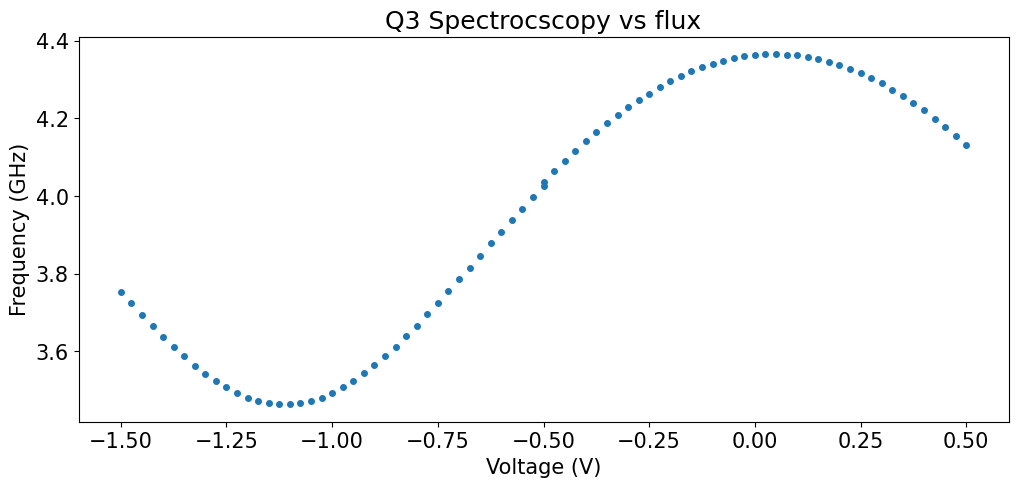

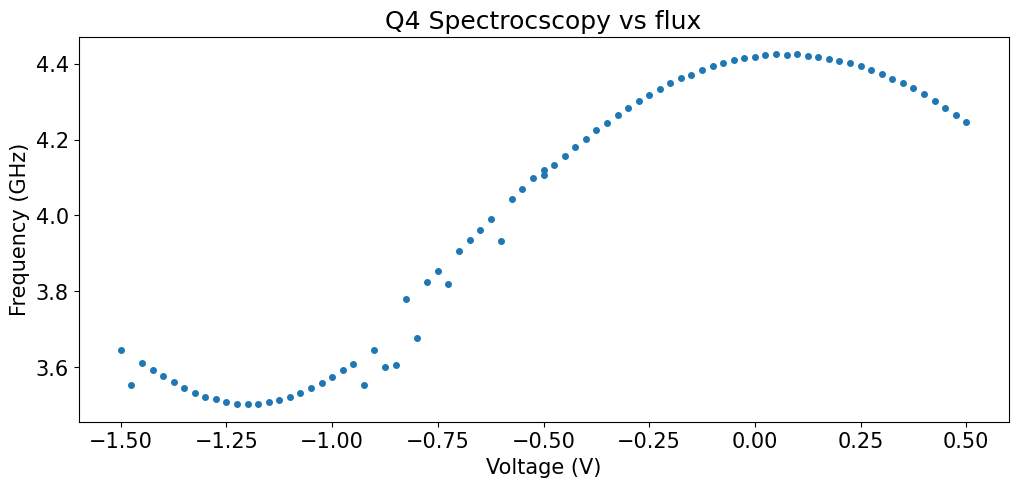

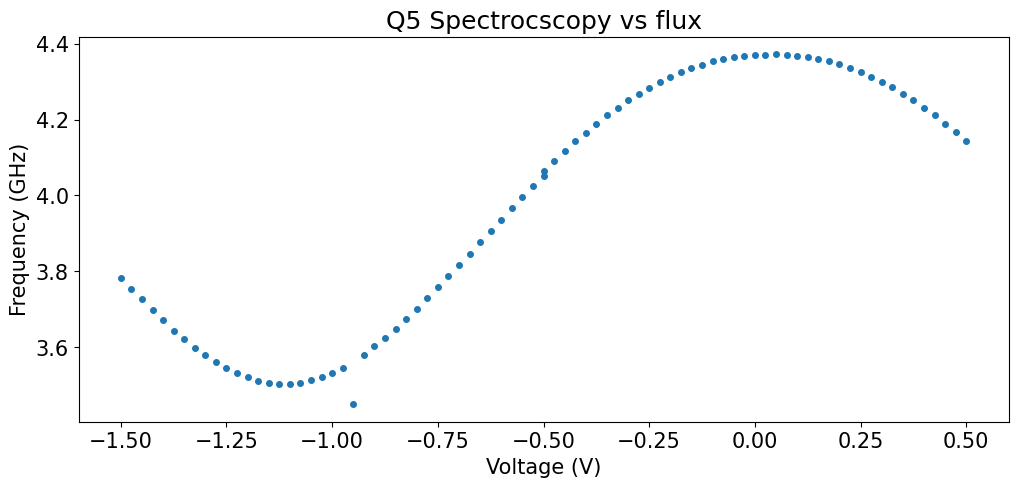

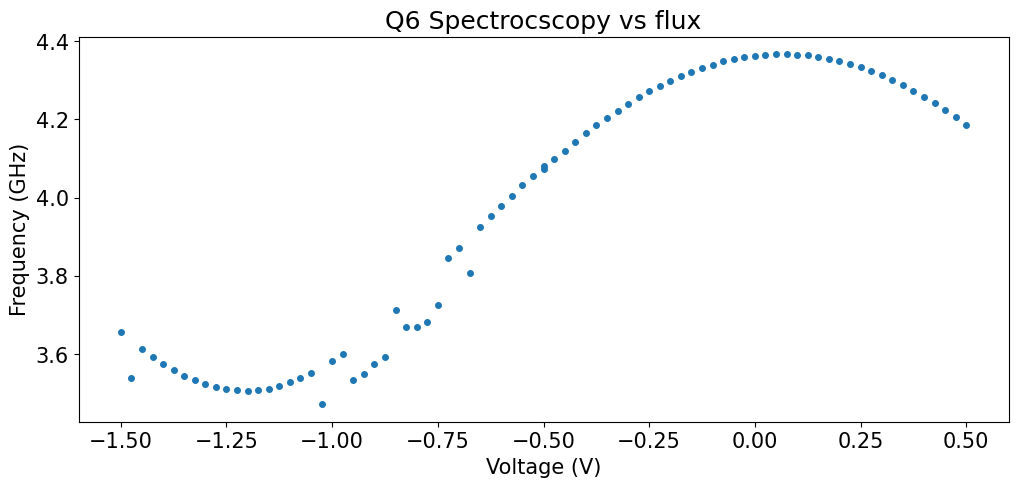

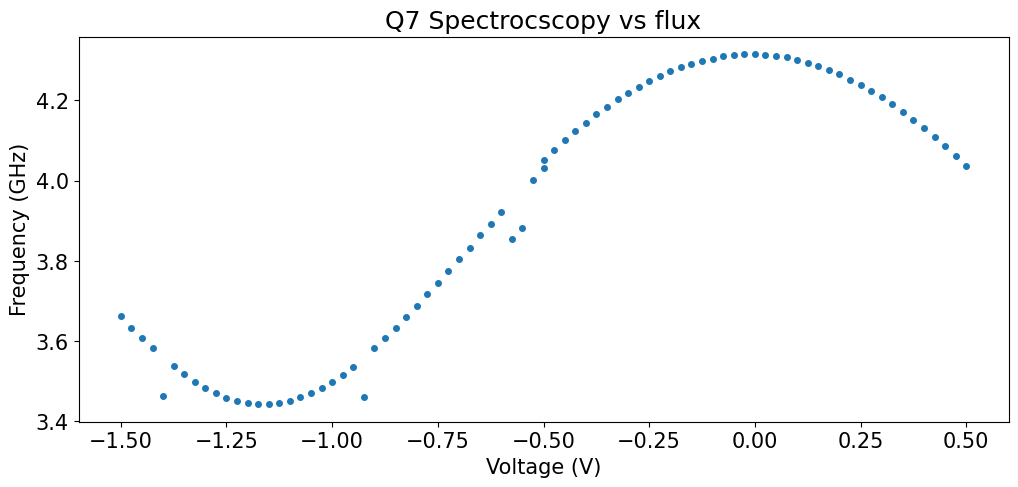

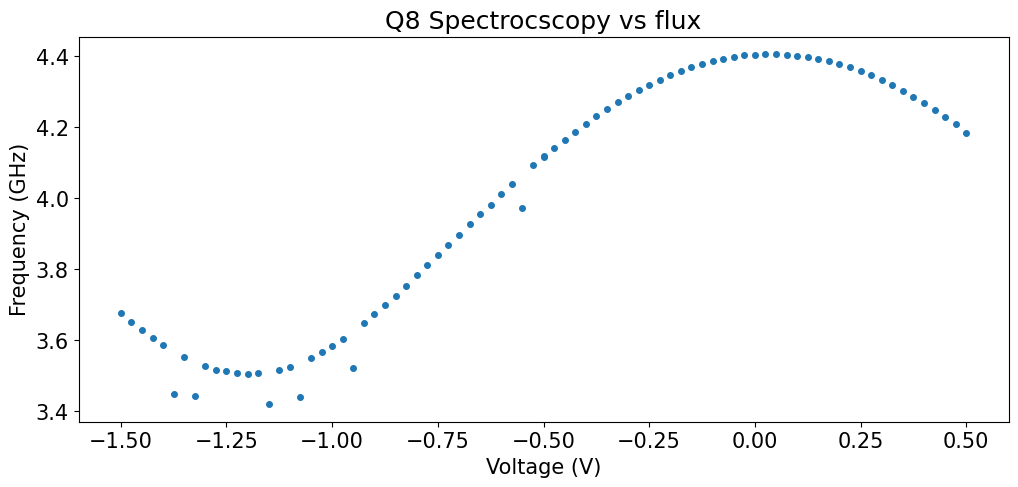

In [25]:
for qubit in all_qubits:
    if qubit in qubit_to_frequencies and qubit in qubit_to_voltages: 
        
        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]
        
        if len(frequencies) > 0:

            plt.plot(voltages, frequencies, marker='o', linestyle='', ms=4)

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.title(f'{qubit} Spectrocscopy vs flux')

            plt.show()

### 2.3 Find points to ignore

In [26]:
qubit_to_filtered_voltages = {}
qubit_to_filtered_frequencies = {}

qubit_to_ignore_indices_expanded = {}

In [92]:
'''
define indices to ignore as list of indices
each element is an index or a tuple of index
if index, add that index to set of indices to ignore
if tuple (i1, i2), add the range [i1, i2) to the set of indices to ignore 
'''

qubit_to_ignore_indices = {}

qubit_to_ignore_indices['Q1'] = []

qubit_to_ignore_indices['Q2'] = [23, 28]

qubit_to_ignore_indices['Q3'] = []

qubit_to_ignore_indices['Q4'] = [1, 23, 25, 26, 28, 31, 36]

qubit_to_ignore_indices['Q5'] = [22]

qubit_to_ignore_indices['Q6'] = [1, 19, (22, 26), (27, 31), 33]

qubit_to_ignore_indices['Q7'] = [4, 23, 37, 38]

qubit_to_ignore_indices['Q8'] = [5, 7, 14, 17, 22, 38]




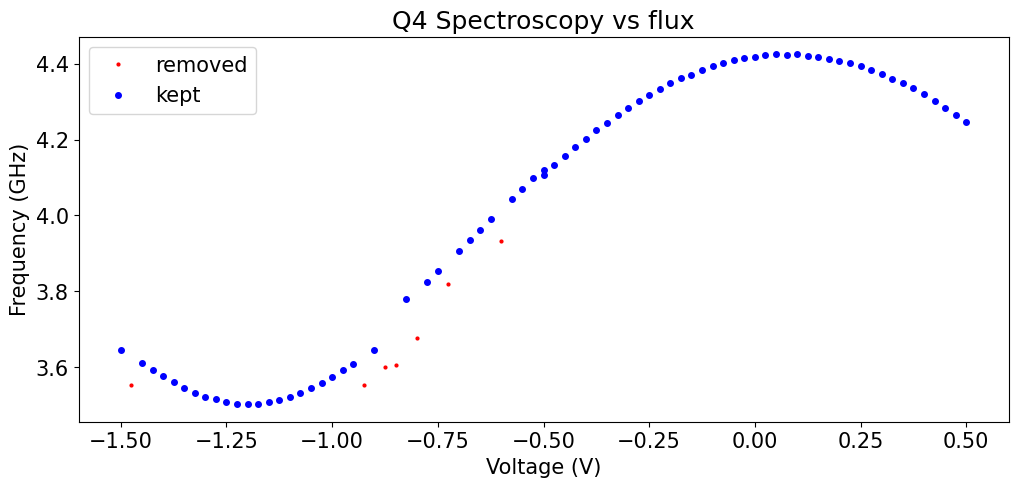

In [101]:
filter_qubits = all_qubits
filter_qubits = ['Q4']

for qubit in filter_qubits:
    if qubit in qubit_to_frequencies and qubit in qubit_to_voltages: 
        
        voltages = qubit_to_voltages[qubit]
        frequencies = qubit_to_frequencies[qubit]
        
        if len(frequencies) > 0:
            
            ignore_indices = qubit_to_ignore_indices[qubit]
            

            # expand tuple ranges into their explicit set of indices
            ignore_indices_expanded = set()

            for i in range(len(ignore_indices)):
                ignore_index = ignore_indices[i]
                if isinstance(ignore_index, int):
                    ignore_indices_expanded.add(ignore_index)
                elif isinstance(ignore_index, (tuple, list)):
                    ignore_indices_expanded.update(range(ignore_index[0], ignore_index[1]))
                    

            inverse_ignore_indices = set(range(len(voltages))) - ignore_indices_expanded
            inverse_ignore_indices = list(inverse_ignore_indices)
            
            qubit_to_ignore_indices_expanded[qubit] = list(ignore_indices_expanded)
            
            qubit_to_filtered_voltages[qubit] = np.copy(voltages)[inverse_ignore_indices]
            qubit_to_filtered_frequencies[qubit] = np.copy(frequencies)[inverse_ignore_indices]
            
            
            plt.plot(voltages[list(ignore_indices_expanded)], frequencies[list(ignore_indices_expanded)], marker='o', linestyle='', ms=2, color='red', label='removed')
            plt.plot(qubit_to_filtered_voltages[qubit], qubit_to_filtered_frequencies[qubit], marker='o', linestyle='', ms=4, color='blue', label='kept')
#             plt.plot(voltages, frequencies, alpha=0)

#             plt.xlim(1.15, 1.4)

            plt.xlabel('Voltage (V)')
            plt.ylabel('Frequency (GHz)')

            plt.legend()

            plt.title(f'{qubit} Spectroscopy vs flux')

            plt.show()           

# 3. Fit Spectrum to Model

### 3.1 Transmon Model

In [96]:
def frequency_model_fit(x, x0, a, b, c, d):
    return np.sqrt(a*np.sqrt(np.power(np.cos(b*(x-x0)),2) + (d**2)*np.power(np.sin(b*(x-x0)),2))) - c

In [97]:
# initial guesses
qubit_to_transmon_initial_guess = {}

qubit_to_transmon_initial_guess['Q1'] = [-0.5, 30, 1.2, 0.17405, 0.6]
qubit_to_transmon_initial_guess['Q2'] = [-0.5, 30, 1.2, 0.17405, 0.6]
qubit_to_transmon_initial_guess['Q3'] = [-0.5, 30, 1.2, 0.17405, 0.6]
qubit_to_transmon_initial_guess['Q4'] = [-0.5, 30, 1.2, 0.17405, 0.6]
qubit_to_transmon_initial_guess['Q5'] = [-0.5, 30, 1.2, 0.17405, 0.6]
qubit_to_transmon_initial_guess['Q6'] = [-0.5, 30, 1.2, 0.17405, 0.6]
qubit_to_transmon_initial_guess['Q7'] = [-0.5, 30, 1.2, 0.17405, 0.6]
qubit_to_transmon_initial_guess['Q8'] = [-0.5, 30, 1.2, 0.17405, 0.6]

# bounds
qubit_to_transmon_bounds = {}

qubit_to_transmon_bounds['Q1'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))
qubit_to_transmon_bounds['Q2'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))
qubit_to_transmon_bounds['Q3'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))
qubit_to_transmon_bounds['Q4'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))
qubit_to_transmon_bounds['Q5'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))
qubit_to_transmon_bounds['Q6'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))
qubit_to_transmon_bounds['Q7'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))
qubit_to_transmon_bounds['Q8'] = ((-np.inf, 0, 0, 0.1740, 0), (np.inf, np.inf, np.inf, 0.1741, 1))



In [98]:
# transmon popts, pcovs
qubit_to_transmon_popts = {}
qubit_to_transmon_err = {}

[ 0.0850534  20.90650998  1.34194542  0.174       0.6538879 ]


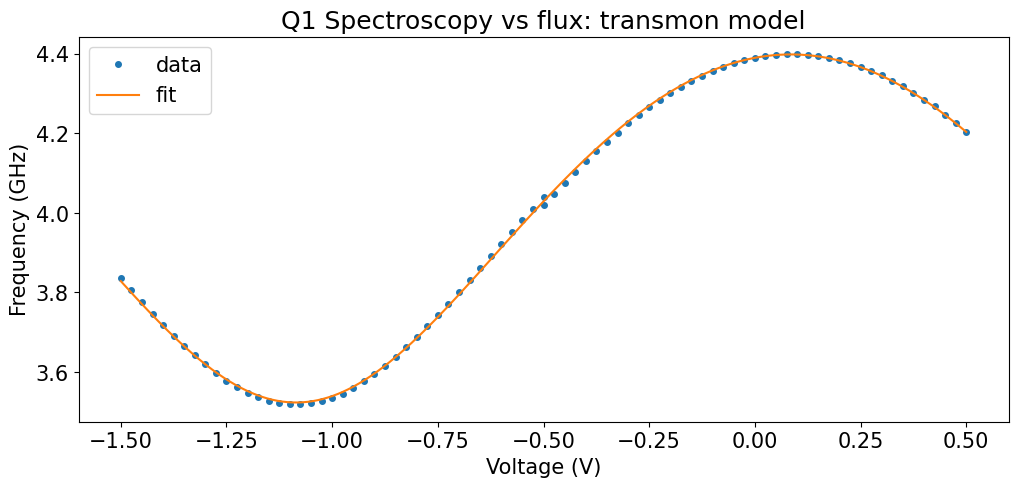

[ 0.06440761 21.00849279  1.27122502  0.174       0.64701663]


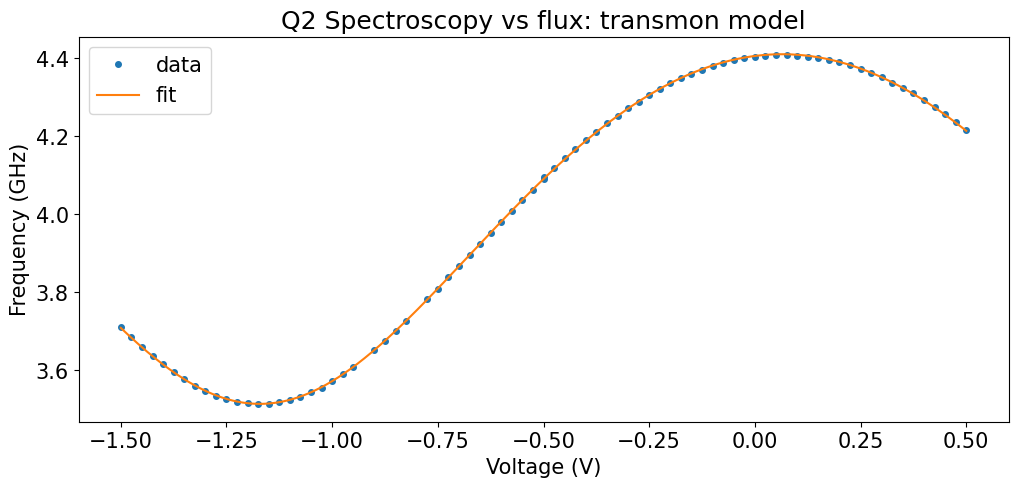

[ 0.04550348 20.63500388  1.35513857  0.174       0.64107531]


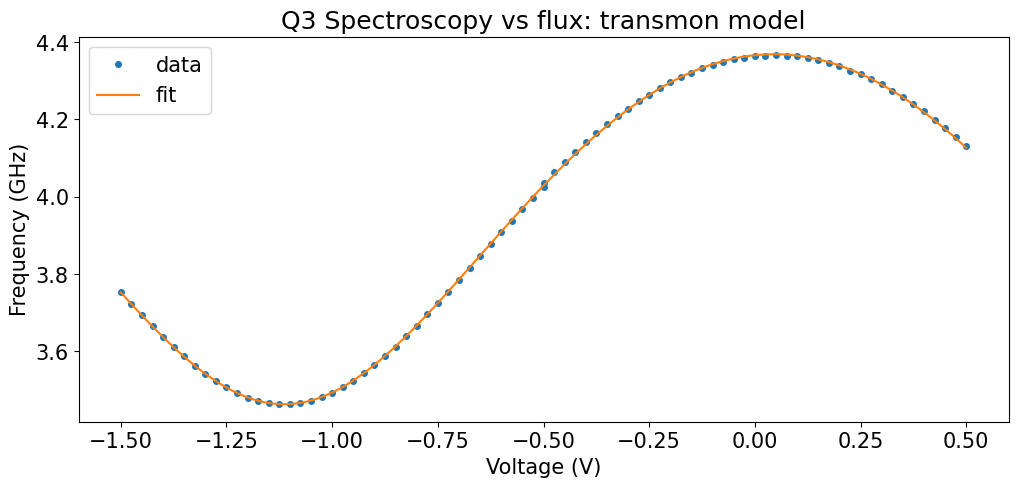

[ 0.07080849 21.15251707  1.22556763  0.174       0.6391645 ]


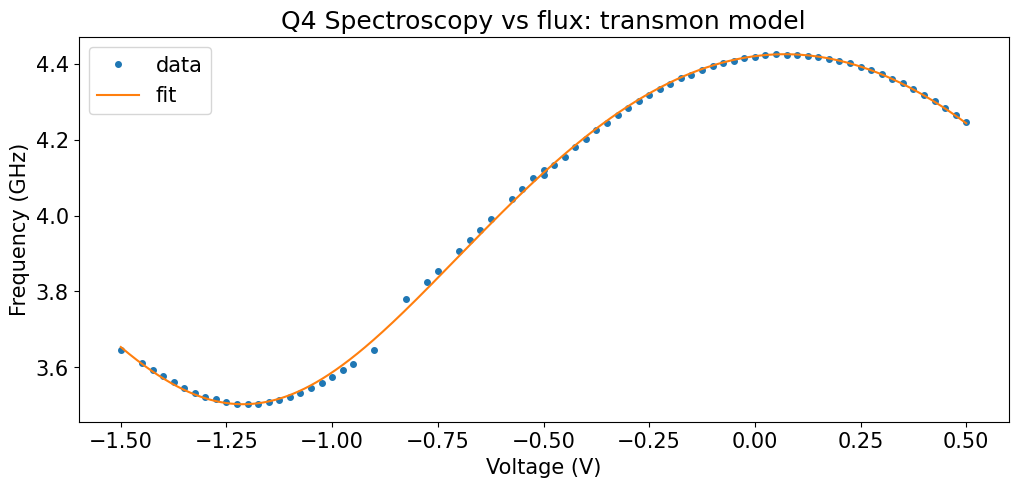

[ 0.03926925 20.7402388   1.36009976  0.174       0.65240258]


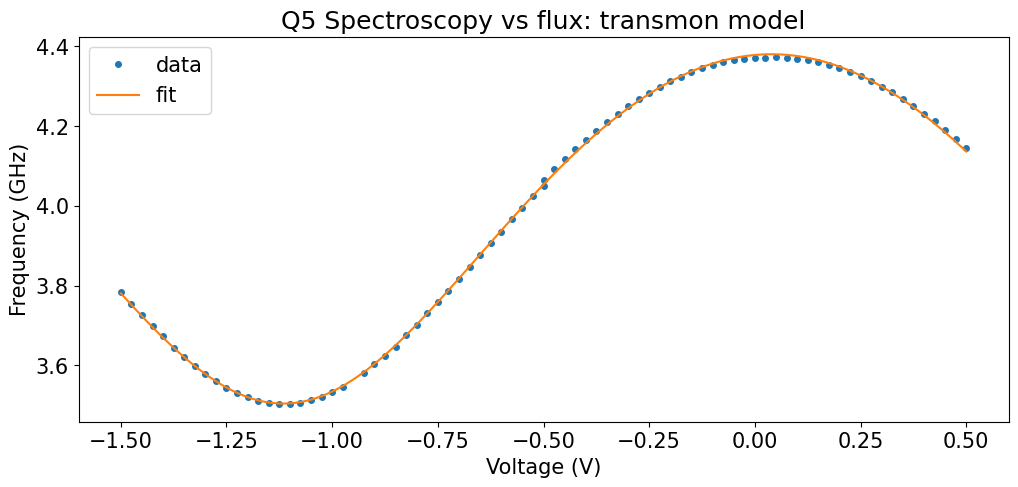

[ 0.06254911 20.62692867  1.23709763  0.174       0.65735401]


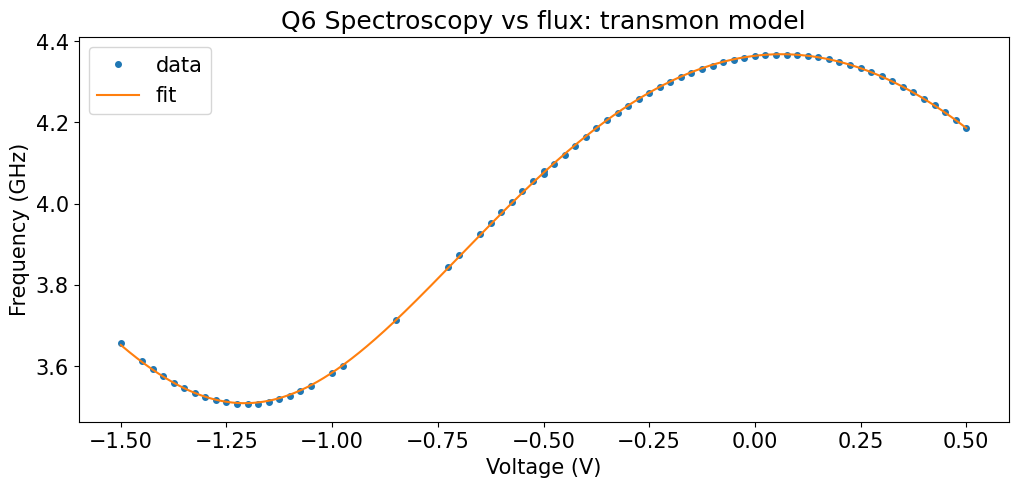

[-3.86944701e-03  2.01762649e+01  1.35658225e+00  1.74100000e-01
  6.47399820e-01]


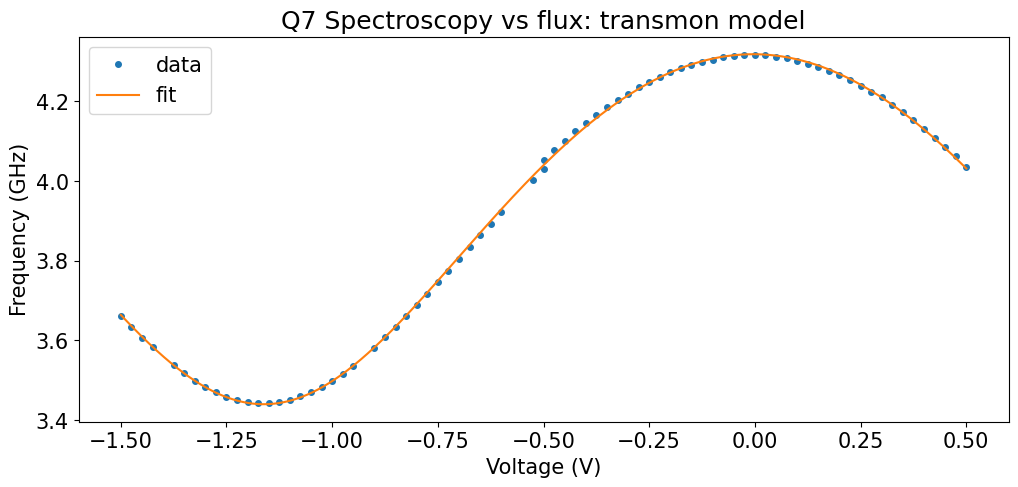

[ 0.03515135 20.9826715   1.27151166  0.174       0.64605487]


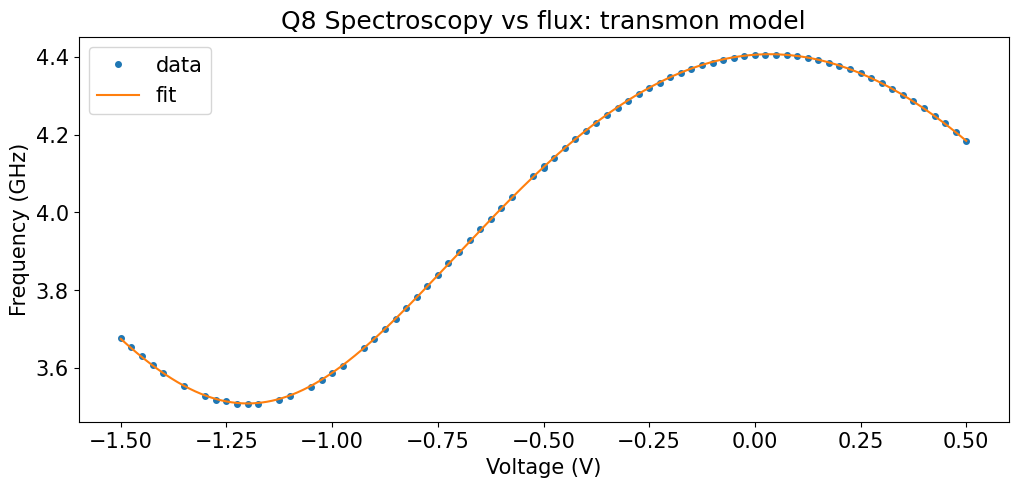

In [99]:
spec_fit_qubits = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
spec_fit_qubits = ['Q1', 'Q2']
spec_fit_qubits = all_qubits
show_guess = False

for qubit in spec_fit_qubits:
    transmon_initial_guess = qubit_to_transmon_initial_guess[qubit]
    transmon_bounds = qubit_to_transmon_bounds[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    filtered_frequencies = qubit_to_filtered_frequencies[qubit]

    fit_voltages = np.linspace(voltages[0], voltages[-1], 1001)
    
    plt.plot(filtered_voltages, filtered_frequencies, marker='o', linestyle='', ms=4, label='data')
    
    if show_guess:
        plt.plot(fit_voltages, frequency_model_fit(fit_voltages, *transmon_initial_guess), label='guess')
    
    # fit
    transmon_popt, transmon_pcov = curve_fit(frequency_model_fit, filtered_voltages, filtered_frequencies, p0=transmon_initial_guess, bounds=transmon_bounds)
    print(transmon_popt)
    
    qubit_to_transmon_popts[qubit] = transmon_popt
    
    transmon_err = np.sqrt(np.diag(transmon_pcov))
    qubit_to_transmon_err[qubit] = transmon_err

    plt.plot(fit_voltages, frequency_model_fit(fit_voltages, *transmon_popt), label='fit')
    
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')

    plt.title(f'{qubit} Spectroscopy vs flux: transmon model')

    plt.legend()

    plt.show()

In [ ]:
for qubit in qubit_to_transmon_popts:

    transmon_popt = qubit_to_transmon_popts[qubit]
    transmon_err = qubit_to_transmon_err[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    

    plt.plot(voltages, frequency_model_fit(voltages, *transmon_popt), label=qubit)

plt.xlabel('Voltage (V)')
plt.ylabel('$E_J$ (nH)')
plt.legend()

plt.title(f'{qubit}: $E_J$ vs voltage')
plt.show()

In [103]:
### export tunable transmon model parameters

export_fit_qubits = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
export_fit_qubits = ['Q1', 'Q2']
export_fit_qubits = all_qubits

for qubit in export_fit_qubits:
    
    filename = f'tunable_transmon_model_parameters\\{qubit}.csv'
        
    popt = qubit_to_transmon_popts[qubit]

    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)

        first_row = ['x0', 'a', 'b', 'c', 'd']
        writer.writerow(first_row)
        writer.writerow(popt)

### 3.3 Extract parameters

$$\omega = 2\pi\sqrt{8 E_c E_J} - 2\pi{E_c}$$

$$L_J = \frac{\Phi_0^2}{(2\pi)^2E_J}$$

$$E_J = E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi\Phi}{\Phi_0}\right)} + d^2\sin^2{\left(\frac{\pi\Phi}{\Phi_0}\right)}}$$

$$E_{J\text{max}} = E_{J1} + E_{J2}$$

$$d = \frac{E_{J2} - E_{J1}}{E_{J2} + E_{J1}}$$



Phase is current times mutual inductance
$$\Phi = MI$$ 

Relate to voltage
$$\Phi = \frac{MV}{R}$$ 

Flux quantum
$$\Phi_0 = \frac{h}{2e}$$




$$\omega = 2\pi\sqrt{8 E_c E_{J\text{max}}\sqrt{\cos^2{\left(\frac{\pi MV}{\Phi_0R}\right)} + d^2\sin^2{\left(\frac{\pi MV}{\Phi_0R}\right)}}} - E_c$$

$$\omega = 2\pi\sqrt{a\sqrt{\cos^2{\left(b(V-x_0)\right)} + d^2\sin^2{\left(b(V-x_0)\right)}}} - c$$

$$a = 8E_cE_{J\text{max}}$$

$$b = \frac{\pi M}{\Phi_0 R}$$

$$c = E_c$$



In [104]:
# define constants

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi_0 = h/(2*e)


In [105]:
extract_param_qubits = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
extract_param_qubits = ['Q1', 'Q2']
extract_param_qubits = all_qubits

qubit_to_Ec = {}
qubit_to_E_J_1 = {}
qubit_to_E_J_2 = {}

for qubit in extract_param_qubits:
    
    transmon_popt = qubit_to_transmon_popts[qubit]
    transmon_err = qubit_to_transmon_err[qubit]
    
    x0, a, b, c, d = transmon_popt
    x0_err, a_err, b_err, c_err, d_err = transmon_err

    # x0 is phase offset
    # b has information about the mutual inductance and resistance of the fluxline
    # c has information about Ec
    # d has information aobut the percent difference between E_J1 and E_J2

    print(f'{qubit}:')
    
    E_c = c
    qubit_to_Ec[qubit] = E_c
    print(f'\tE_c = {np.round(E_c*1e3, 2)} MHz')
    
    E_J_max = a/(8*E_c)
    print(f'\tE_J_max = {np.round(E_J_max, 2)} GHz')

    # EJ2 - EJ1 = d*E_J_max
    E_J_2 = (d+1)*E_J_max/2
    E_J_1 = (1-d)*E_J_max/2

    print(f'\tE_J_1 = {np.round(E_J_1, 2)} GHz')
    print(f'\tE_J_2 = {np.round(E_J_2, 2)} GHz')

    qubit_to_E_J_1[qubit] = E_J_1
    qubit_to_E_J_2[qubit] = E_J_2
    



Q1:
	E_c = 174.0 MHz
	E_J_max = 15.02 GHz
	E_J_1 = 2.6 GHz
	E_J_2 = 12.42 GHz
Q2:
	E_c = 174.0 MHz
	E_J_max = 15.09 GHz
	E_J_1 = 2.66 GHz
	E_J_2 = 12.43 GHz
Q3:
	E_c = 174.0 MHz
	E_J_max = 14.82 GHz
	E_J_1 = 2.66 GHz
	E_J_2 = 12.16 GHz
Q4:
	E_c = 174.0 MHz
	E_J_max = 15.2 GHz
	E_J_1 = 2.74 GHz
	E_J_2 = 12.45 GHz
Q5:
	E_c = 174.0 MHz
	E_J_max = 14.9 GHz
	E_J_1 = 2.59 GHz
	E_J_2 = 12.31 GHz
Q6:
	E_c = 174.0 MHz
	E_J_max = 14.82 GHz
	E_J_1 = 2.54 GHz
	E_J_2 = 12.28 GHz
Q7:
	E_c = 174.1 MHz
	E_J_max = 14.49 GHz
	E_J_1 = 2.55 GHz
	E_J_2 = 11.93 GHz
Q8:
	E_c = 174.0 MHz
	E_J_max = 15.07 GHz
	E_J_1 = 2.67 GHz
	E_J_2 = 12.41 GHz


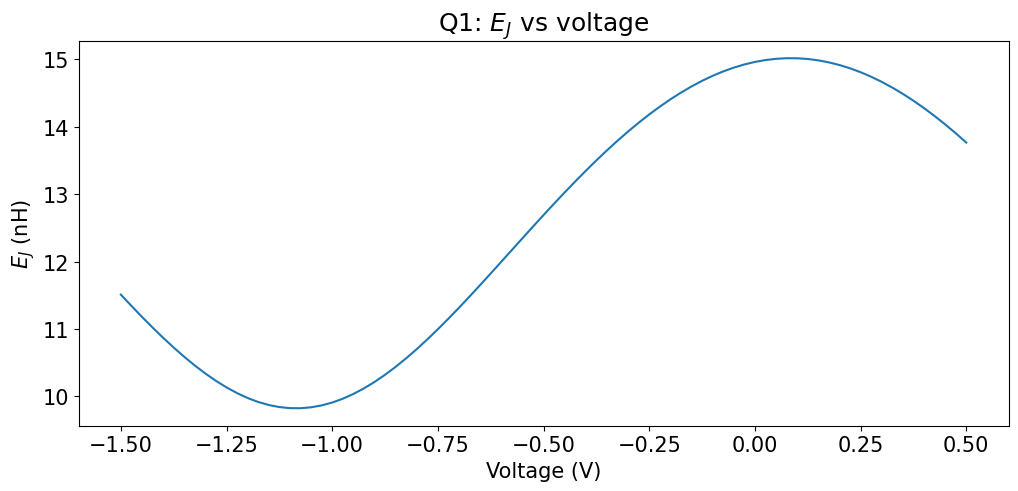

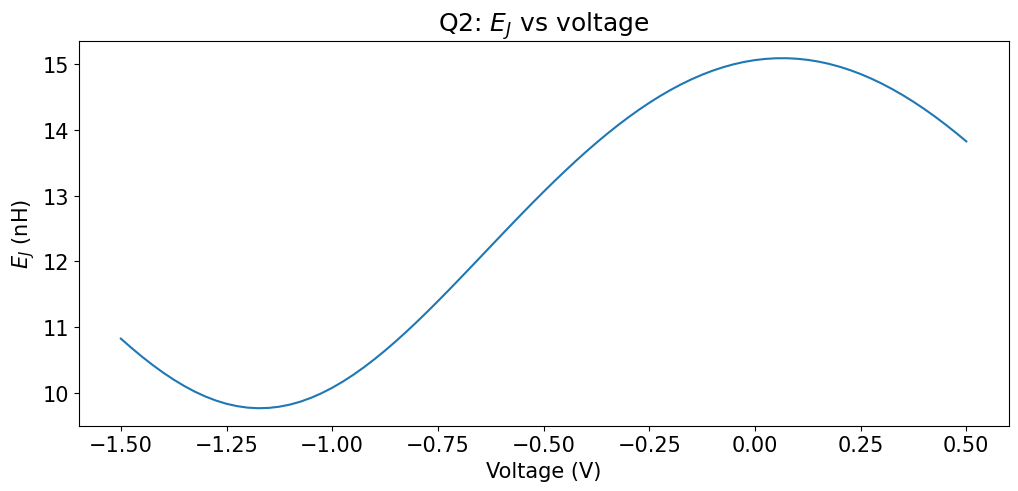

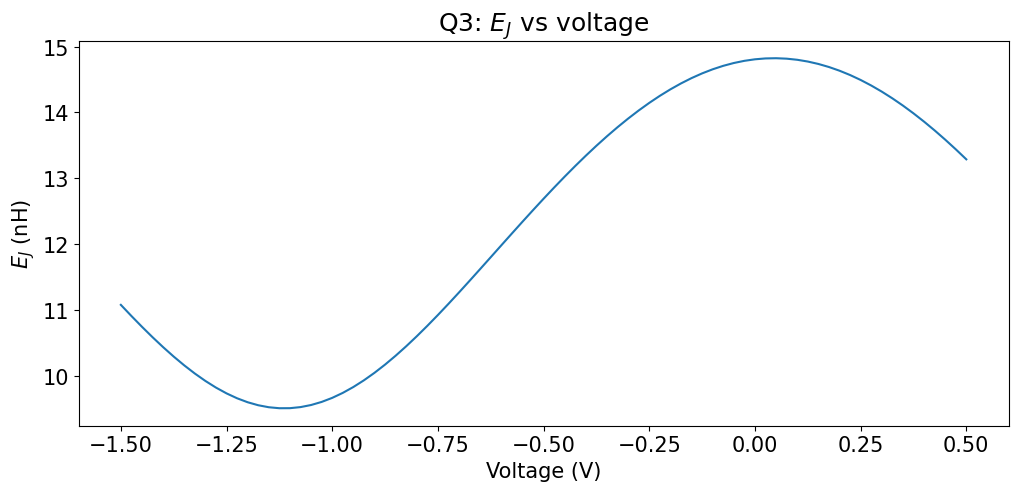

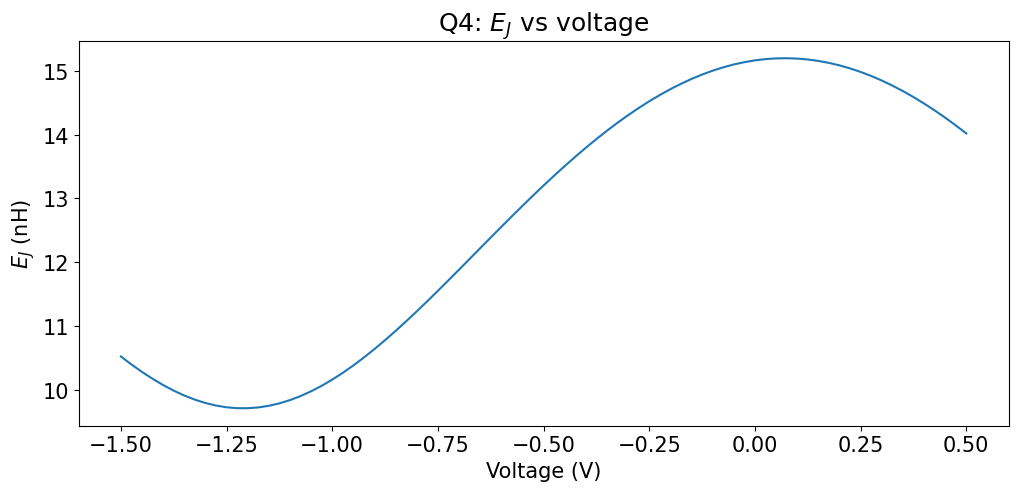

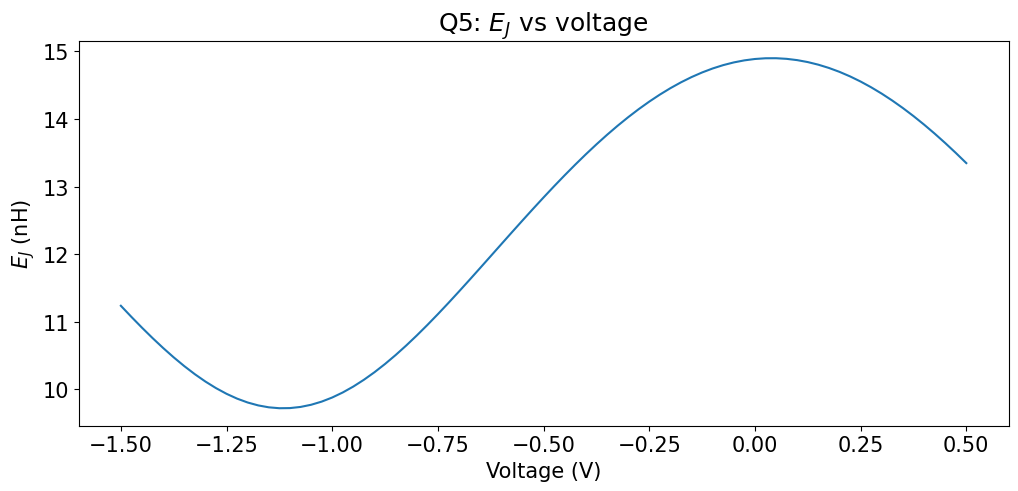

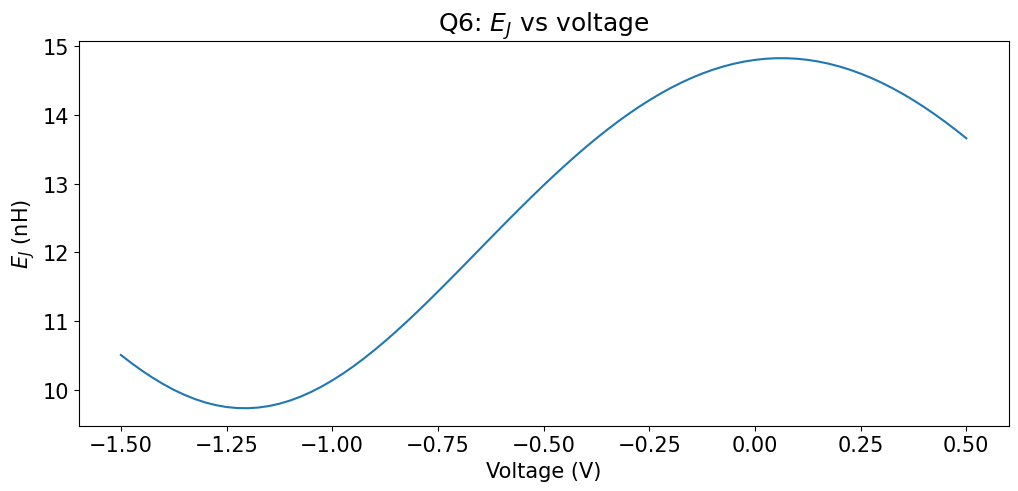

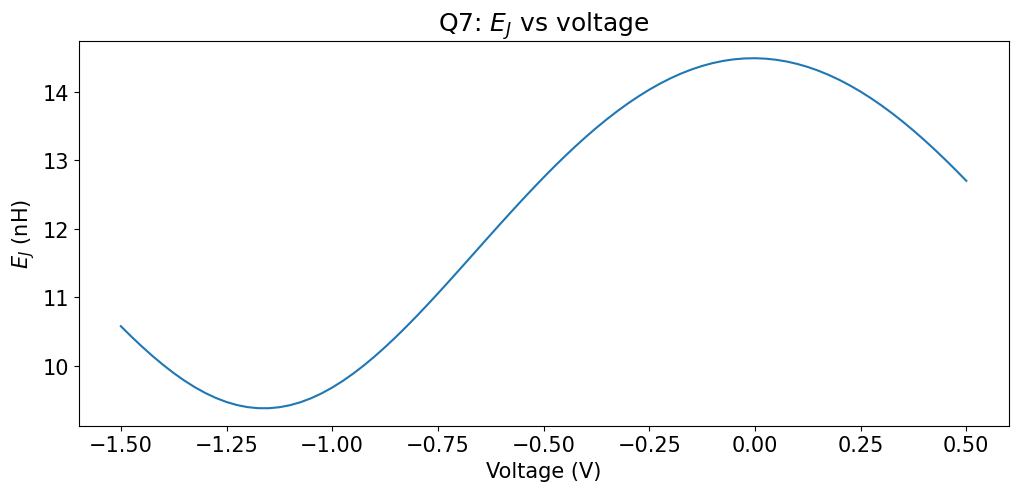

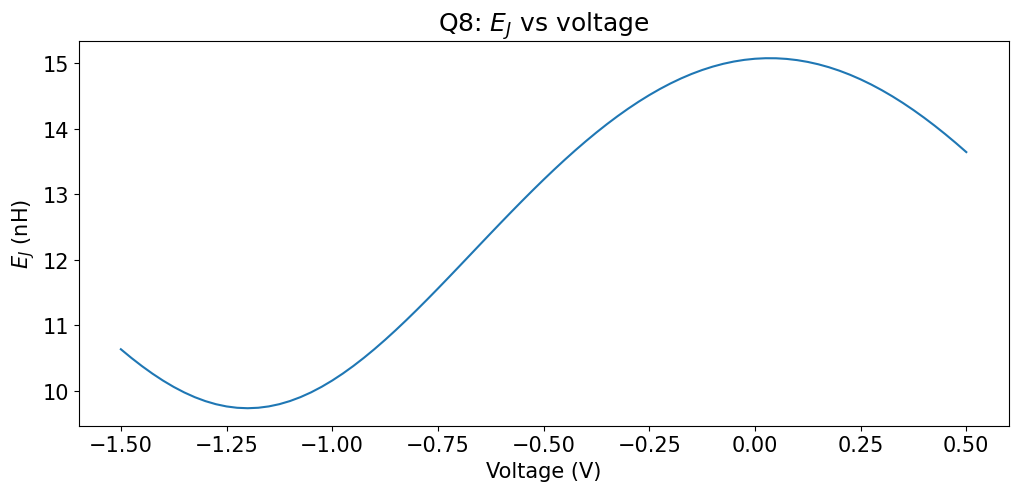

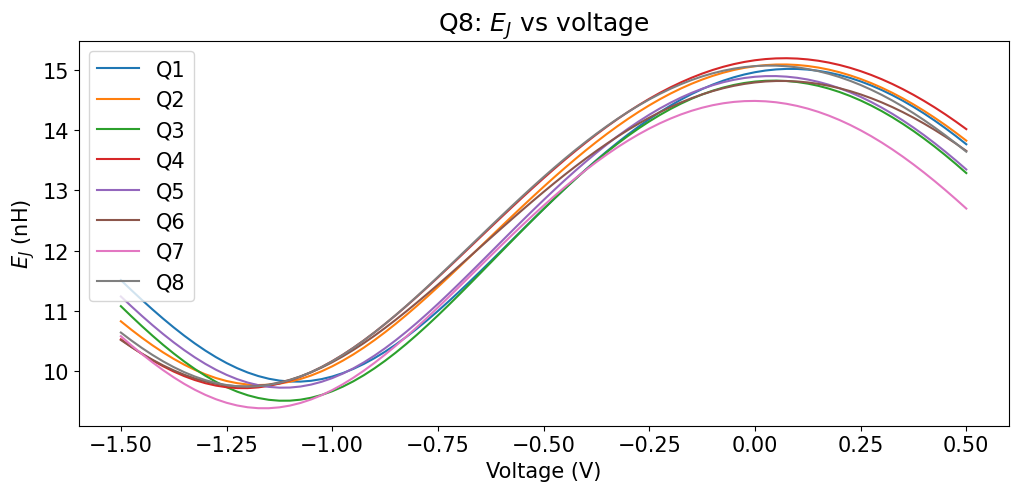

In [ ]:
### plot EJ vs voltage
for qubit in extract_param_qubits:
    
    transmon_popt = qubit_to_transmon_popts[qubit]
    transmon_err = qubit_to_transmon_err[qubit]
    
    voltages = qubit_to_voltages[qubit]
    
    x0, a, b, c, d = transmon_popt
    
    E_J_1 = qubit_to_E_J_1[qubit]
    E_J_2 = qubit_to_E_J_2[qubit]
    E_J_max = E_J_1 + E_J_2
    
    E_J = lambda V: E_J_max*np.sqrt(np.power(np.cos(b*(V-x0)),2) + (d**2)*np.power(np.sin(b*(V-x0)),2))

    plt.plot(voltages, E_J(voltages))

    plt.xlabel('Voltage (V)')
    plt.ylabel('$E_J$ (nH)')

    plt.title(f'{qubit}: $E_J$ vs voltage')
    plt.show()





In [107]:
### flux quantum / voltage period factor


for qubit in extract_param_qubits:
    
    transmon_popt = qubit_to_transmon_popts[qubit]
    transmon_err = qubit_to_transmon_err[qubit]
    
    x0, a, b, c, d = transmon_popt
    x0_err, a_err, b_err, c_err, d_err = transmon_err
    
    print(f'{qubit} voltage period: {round(np.pi/b, 3)} V')

Q1 voltage period: 2.341 V
Q2 voltage period: 2.471 V
Q3 voltage period: 2.318 V
Q4 voltage period: 2.563 V
Q5 voltage period: 2.31 V
Q6 voltage period: 2.539 V
Q7 voltage period: 2.316 V
Q8 voltage period: 2.471 V


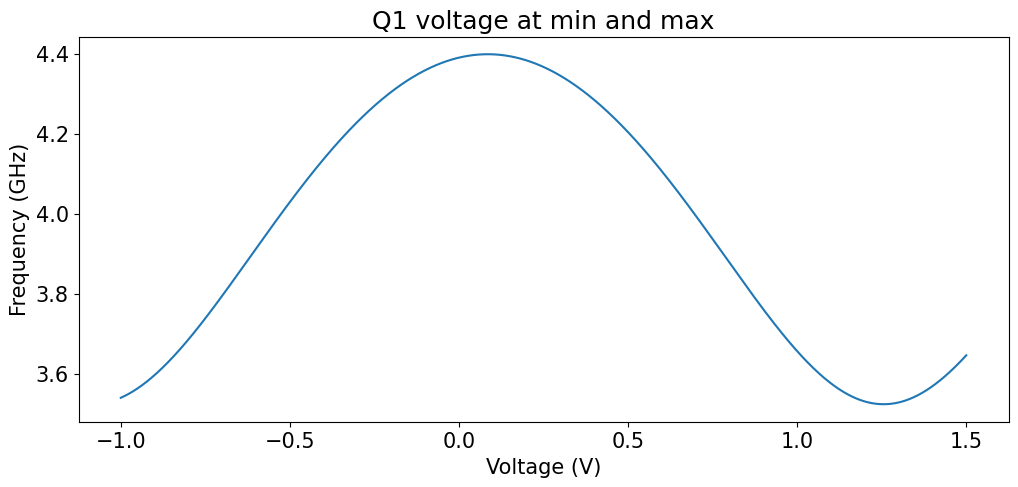

Q1 voltage at min: 1.256 V
Q1 freq min: 3.52
Q1 voltage at max: 0.085 V
Q1 freq max: 4.4



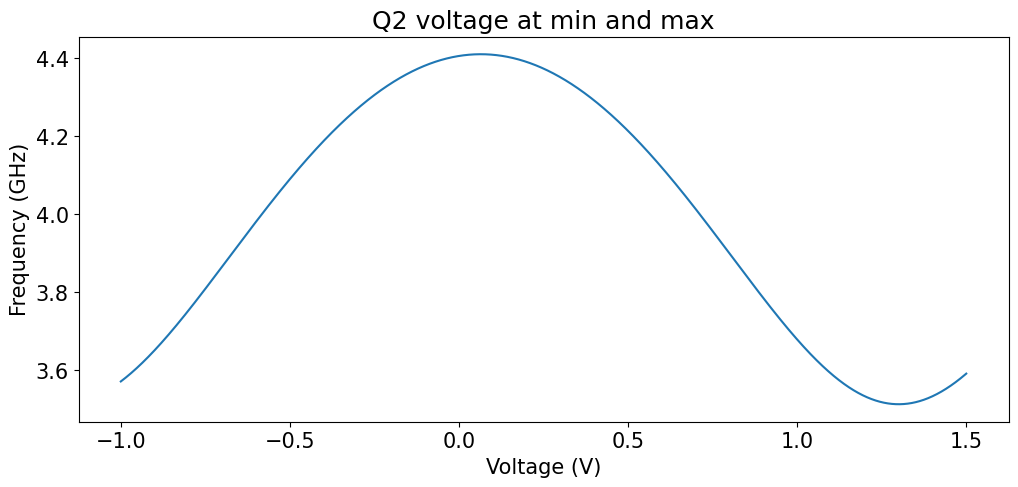

Q2 voltage at min: 1.3 V
Q2 freq min: 3.51
Q2 voltage at max: 0.064 V
Q2 freq max: 4.41



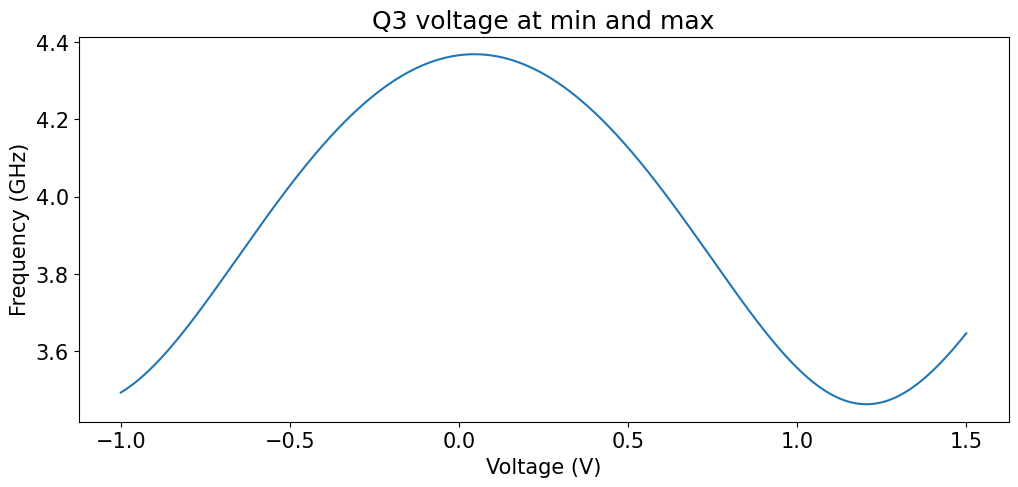

Q3 voltage at min: 1.205 V
Q3 freq min: 3.46
Q3 voltage at max: 0.046 V
Q3 freq max: 4.37



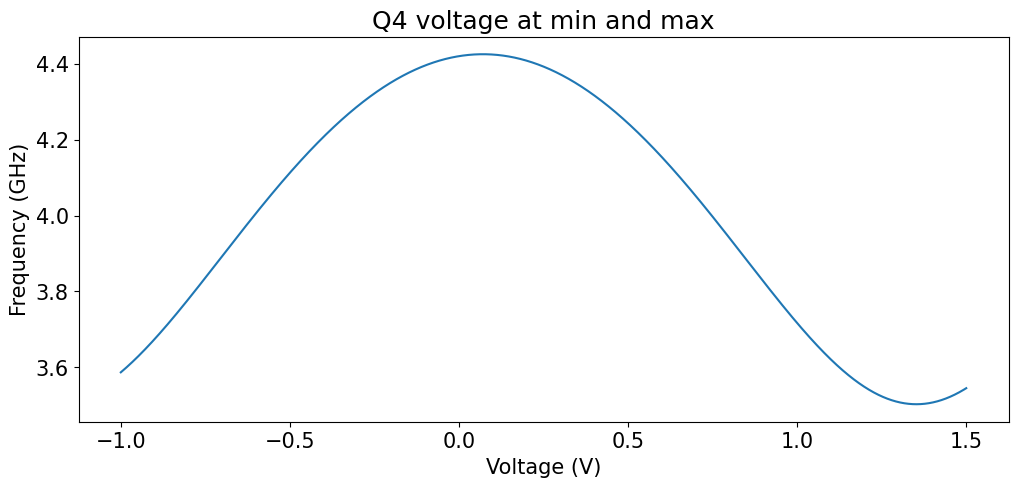

Q4 voltage at min: 1.352 V
Q4 freq min: 3.5
Q4 voltage at max: 0.071 V
Q4 freq max: 4.43



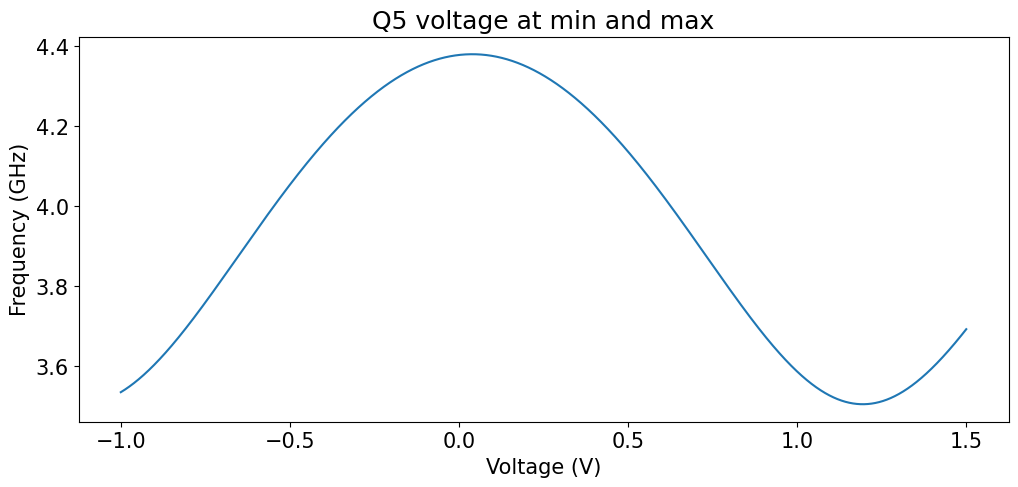

Q5 voltage at min: 1.194 V
Q5 freq min: 3.5
Q5 voltage at max: 0.039 V
Q5 freq max: 4.38



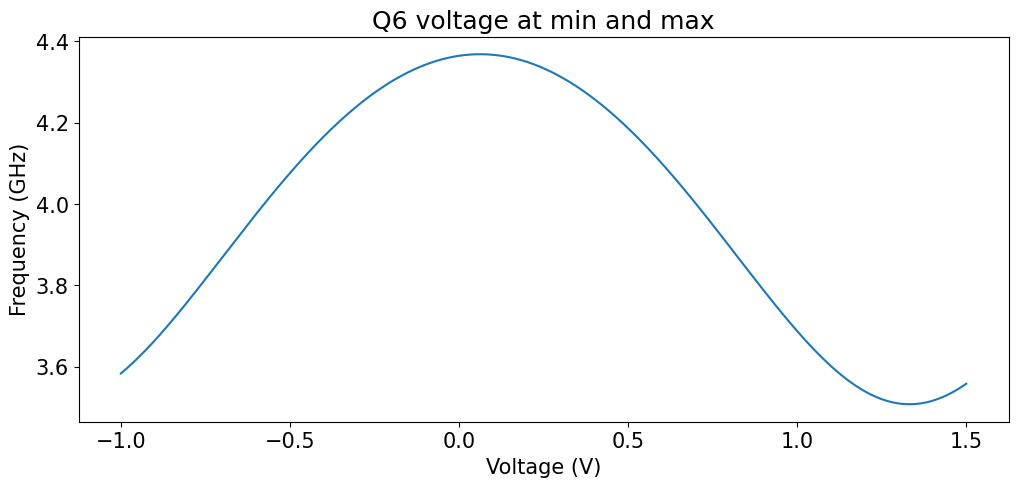

Q6 voltage at min: 1.332 V
Q6 freq min: 3.51
Q6 voltage at max: 0.062 V
Q6 freq max: 4.37



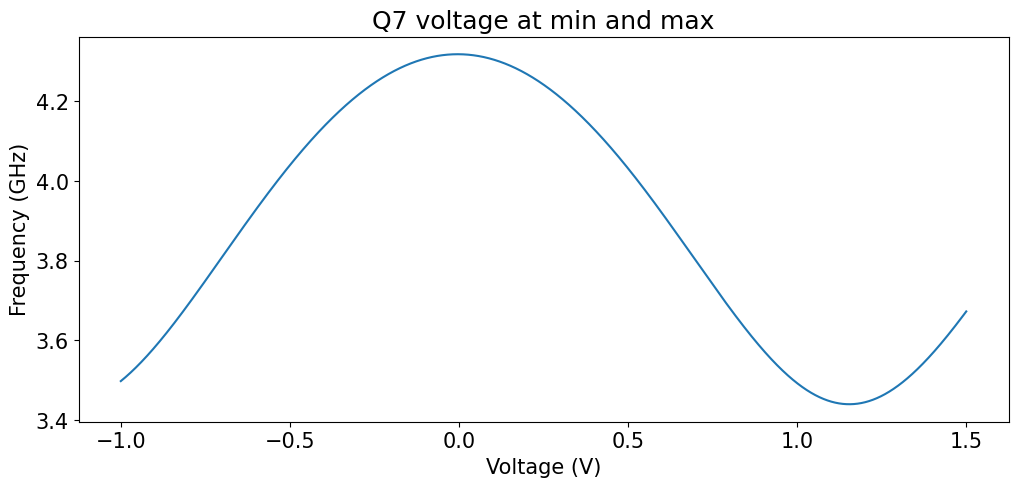

Q7 voltage at min: 1.154 V
Q7 freq min: 3.44
Q7 voltage at max: -0.004 V
Q7 freq max: 4.32



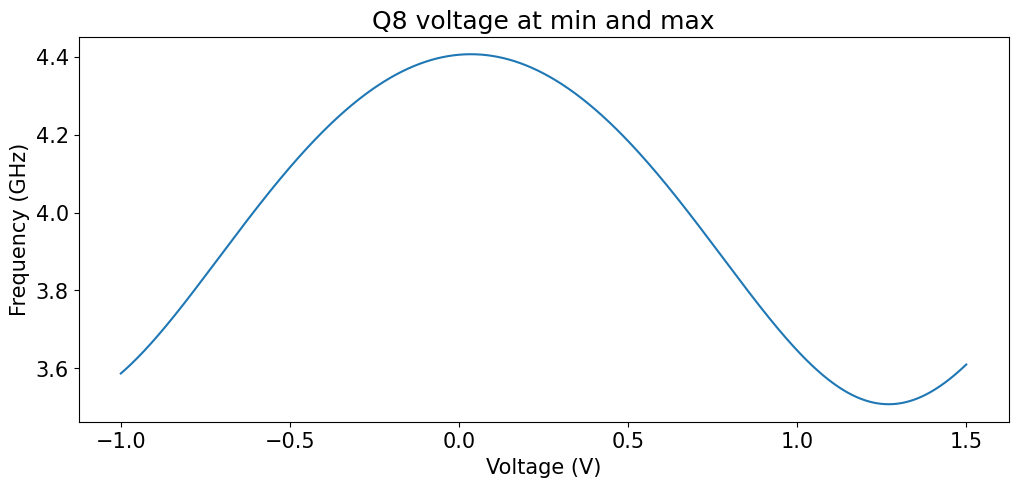

Q8 voltage at min: 1.271 V
Q8 freq min: 3.51
Q8 voltage at max: 0.035 V
Q8 freq max: 4.41



In [108]:
### voltage at min/max

for qubit in extract_param_qubits:
    
    transmon_popt = qubit_to_transmon_popts[qubit]
    filtered_voltages = qubit_to_filtered_voltages[qubit]
    
    if qubit == 'Q2':
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    elif qubit == 'Q3':
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
    else:
        fit_voltages = np.linspace(filtered_voltages[0], filtered_voltages[-1], 10001)
        
    fit_voltages = np.linspace(-1, 1.5, 10001)
    fit_frequnecies = frequency_model_fit(fit_voltages, *transmon_popt)
    
    plt.plot(fit_voltages, fit_frequnecies)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Frequency (GHz)')
    
    plt.title(f'{qubit} voltage at min and max')
    
    plt.show()
    
    print(f'{qubit} voltage at min: {round(fit_voltages[np.argmin(fit_frequnecies)], 3)} V')
    print(f'{qubit} freq min: {round(np.min(fit_frequnecies),2)}')
    print(f'{qubit} voltage at max: {round(fit_voltages[np.argmax(fit_frequnecies)], 3)} V') 
    print(f'{qubit} freq max: {round(np.max(fit_frequnecies),2)}')

    print()

In [43]:
frequency_model_fit(0.15, *qubit_to_transmon_popts['Q1'])


4.393557543412777

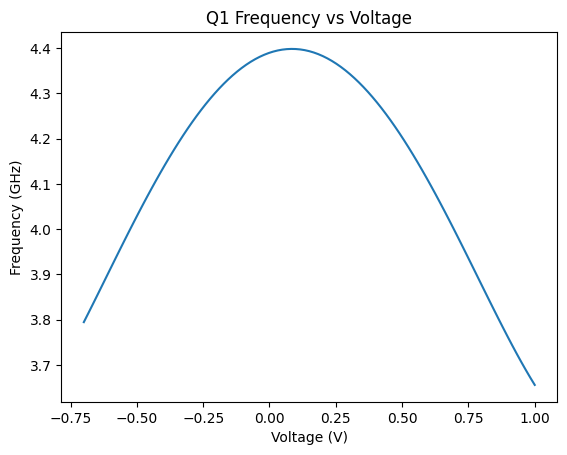

In [44]:
transmon_popt = qubit_to_transmon_popts['Q1']

fit_voltages = np.linspace(-0.7, 1, 101)
fit_frequnecies = frequency_model_fit(fit_voltages, *transmon_popt)

plt.plot(fit_voltages, fit_frequnecies)
plt.xlabel('Voltage (V)')
plt.ylabel('Frequency (GHz)')

plt.title('Q1 Frequency vs Voltage')

plt.show()

### 3.4 Define functions for frequencies vs flux

In [112]:
qubit_to_function = {}
qubit_to_inverse_function = {}

qubit_to_flux_to_voltage = {}
qubit_to_voltage_to_flux = {}

# function_qubits = ['Q2', 'Q3', 'Q4']
function_qubits = ['Q1', 'Q2']
function_qubits = all_qubits

for qubit in function_qubits:
    
    tramsmon_popt = qubit_to_transmon_popts[qubit]
    
    x0, a, b, c, d = tramsmon_popt
    
    def create_qubit_flux_to_voltage(_popt):
        x0, a, b, c, d = _popt
        return lambda x: (np.pi*x)/b + x0
    
    def create_qubit_voltage_to_flux(_popt):
        x0, a, b, c, d = _popt
        return lambda x: b*(x - x0)/np.pi
    
    qubit_to_flux_to_voltage[qubit] = create_qubit_flux_to_voltage(tramsmon_popt)
    qubit_to_voltage_to_flux[qubit] = create_qubit_voltage_to_flux(tramsmon_popt)
    
    # takes a flux value and outputs frequency
    def create_qubit_function(_popt):
        x0, a, b, c, d = _popt
        return lambda x: frequency_model_fit((np.pi*x)/b + x0, *_popt)
    
    qubit_function = create_qubit_function(tramsmon_popt)
    qubit_to_function[qubit] = qubit_function
    
    # takes a frequency value and outputs flux
    def create_qubit_inverse_function(qubit_function):
        def find_root(f, __qubit_function):
            bracket = (0, 0.5)

            if isinstance(f, (list, np.ndarray)):
                fluxes = np.empty(len(f))
                for i in range(len(f)):
                    root_function = lambda flux: __qubit_function(flux) - f[i]
                    result = root_scalar(root_function, bracket=bracket)
                    fluxes[i] = result.root
                return fluxes
            elif isinstance(f, (int, float)):
                root_function = lambda flux: __qubit_function(flux) - f
                result = root_scalar(root_function, bracket=bracket)
                return result.root
        return lambda f: find_root(f, qubit_function)
        
    
    qubit_to_inverse_function[qubit] = create_qubit_inverse_function(qubit_function)

if 'Q1' in function_qubits:
    frequency_vs_flux_q1 = qubit_to_function['Q1']
if 'Q2' in function_qubits:
    frequency_vs_flux_q2 = qubit_to_function['Q2']
if 'Q3' in function_qubits:
    frequency_vs_flux_q3 = qubit_to_function['Q3']
if 'Q4' in function_qubits:
    frequency_vs_flux_q4 = qubit_to_function['Q4']
if 'Q5' in function_qubits:
    frequency_vs_flux_q5 = qubit_to_function['Q5']
if 'Q6' in function_qubits:
    frequency_vs_flux_q6 = qubit_to_function['Q6']
if 'Q7' in function_qubits: 
    frequency_vs_flux_q7 = qubit_to_function['Q7']
if 'Q8' in function_qubits:
    frequency_vs_flux_q8 = qubit_to_function['Q8']

In [113]:
for qubit in all_qubits:
    if qubit in qubit_to_function:
        print(f'{qubit}:')
        print(f'\tvoltage at max: {qubit_to_flux_to_voltage[qubit](0)}')
        print(f'\tfrequency at max: {qubit_to_function[qubit](0)}')
        print(f'\tvoltage at min: {qubit_to_flux_to_voltage[qubit](0.5)}')       
        print(f'\tfrequency at min: {qubit_to_function[qubit](0.5)}')
        

Q1:
	voltage at max: 0.08505340460520455
	frequency at max: 4.398363719132015
	voltage at min: 1.2555900738601762
	frequency at min: 3.5233658133268575
Q2:
	voltage at max: 0.06440761152255137
	frequency at max: 4.409502240907642
	voltage at min: 1.3000632213288204
	frequency at min: 3.5128474606806988
Q3:
	voltage at max: 0.04550348123166502
	frequency at max: 4.368576788545354
	voltage at min: 1.2046442198128922
	frequency at min: 3.463113083553201
Q4:
	voltage at max: 0.07080848516532046
	frequency at max: 4.425186566016654
	voltage at min: 1.3524972987791744
	frequency at min: 3.502946834511657
Q5:
	voltage at max: 0.0392692541668814
	frequency at max: 4.3801452323862415
	voltage at min: 1.1941818385510792
	frequency at min: 3.5044487586575404
Q6:
	voltage at max: 0.06254910869459492
	frequency at max: 4.367687865476699
	voltage at min: 1.3322923280610903
	frequency at min: 3.5082811129257467
Q7:
	voltage at max: -0.003869447009597283
	frequency at max: 4.31769974454367
	voltage at

In [114]:
print(f"Q3: {qubit_to_inverse_function['Q3'](4.500)}")

ValueError: f(a) and f(b) must have different signs

In [34]:
print(f'Q2: {frequency_vs_flux_q2(-0.20223535921597208)} GHz')
print(f'Q3: {frequency_vs_flux_q3(0.27418845576705264)} GHz')
print(f'Q4: {frequency_vs_flux_q4(0.10289059446857833)} GHz')

Q2: 4.48767552930464 GHz
Q3: 4.458065452422593 GHz
Q4: 5.177798472539149 GHz


In [35]:
print(f'Q2: {frequency_vs_flux_q2(-0.38342245989304813)} GHz')
print(f'Q3: {frequency_vs_flux_q3(0.35904381716510547)} GHz')
print(f'Q4: {frequency_vs_flux_q4(0.33534183348766183)} GHz')

Q2: 3.428608116506113 GHz
Q3: 3.9138012567802667 GHz
Q4: 4.169587384464079 GHz


In [36]:
print(f'Q4: {frequency_vs_flux_q4(0.35071129700524467)} GHz')

Q4: 4.079957375749438 GHz


In [37]:
print(qubit_to_inverse_function['Q1'](4.4))
print(qubit_to_function['Q1'](-0.27769206))


0.27769205971811156
4.399999998462339


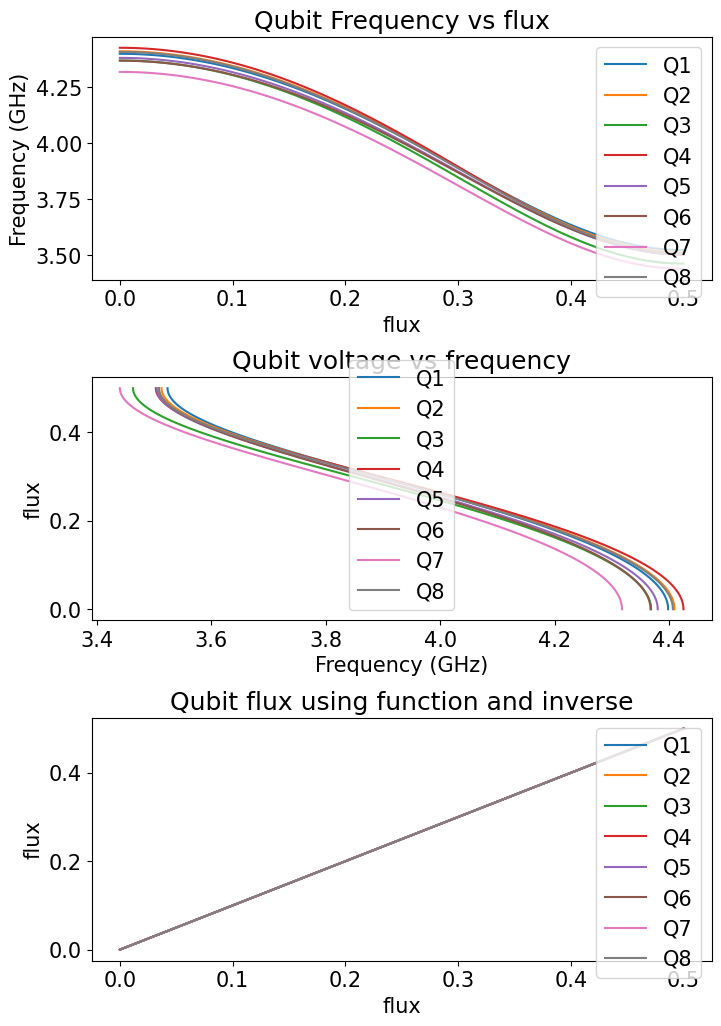

In [115]:
test_fluxes = np.linspace(0, 0.5, 101)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
plt.subplots_adjust(hspace=0.4)

for qubit in function_qubits:
    
    qubit_function = qubit_to_function[qubit]
    qubit_inverse_function = qubit_to_inverse_function[qubit]
    
    test_frequencies = qubit_function(test_fluxes)
    axes[0].plot(test_fluxes, test_frequencies, label=qubit)
    
    # inverse
    axes[1].plot(test_frequencies, qubit_inverse_function(test_frequencies), label=qubit)
    
    axes[2].plot(test_fluxes, qubit_inverse_function(test_frequencies), label=qubit)
    

axes[0].set_xlabel('flux')
axes[0].set_ylabel('Frequency (GHz)')
axes[0].set_title('Qubit Frequency vs flux')
axes[0].legend()

axes[1].set_ylabel('flux')
axes[1].set_xlabel('Frequency (GHz)')
axes[1].set_title('Qubit voltage vs frequency')
axes[1].legend()

axes[2].set_xlabel('flux')
axes[2].set_ylabel('flux')
axes[2].set_title('Qubit flux using function and inverse')
axes[2].legend()

plt.show()

### Functions for Josh

In [39]:
### Qubit voltage to frequency

voltage = 0.5
print(f'Q1: {np.round(frequency_model_fit(voltage, *qubit_to_transmon_popts["Q1"]), 3)} GHz')
print(f'Q2: {np.round(frequency_model_fit(voltage, *qubit_to_transmon_popts["Q2"]), 3)} GHz')
print(f'Q3: {np.round(frequency_model_fit(voltage, *qubit_to_transmon_popts["Q3"]), 3)} GHz')
print(f'Q4: {np.round(frequency_model_fit(voltage, *qubit_to_transmon_popts["Q4"]), 3)} GHz')
print(f'Q5: {np.round(frequency_model_fit(voltage, *qubit_to_transmon_popts["Q5"]), 3)} GHz')

Q1: 5.081 GHz
Q2: 4.616 GHz
Q3: 5.234 GHz
Q4: 5.235 GHz
Q5: 5.208 GHz


In [40]:
### Qubit voltage to flux

voltage = 0
print(f'Q1: {np.round(qubit_to_voltage_to_flux["Q1"](voltage), 3)}')
print(f'Q2: {np.round(qubit_to_voltage_to_flux["Q2"](voltage), 3)}')
print(f'Q3: {np.round(qubit_to_voltage_to_flux["Q3"](voltage), 3)}')
print(f'Q4: {np.round(qubit_to_voltage_to_flux["Q4"](voltage), 3)}')
print(f'Q5: {np.round(qubit_to_voltage_to_flux["Q5"](voltage), 3)}')

Q1: -0.325
Q2: -0.293
Q3: -0.297
Q4: -0.28
Q5: -0.268


In [41]:
### Qubit flux to voltage

flux = 0

print(f'Q1: {np.round(qubit_to_flux_to_voltage["Q1"](flux), 3)} V')
print(f'Q2: {np.round(qubit_to_flux_to_voltage["Q2"](flux), 3)} V')
print(f'Q3: {np.round(qubit_to_flux_to_voltage["Q3"](flux), 3)} V')
print(f'Q4: {np.round(qubit_to_flux_to_voltage["Q4"](flux), 3)} V')
print(f'Q5: {np.round(qubit_to_flux_to_voltage["Q5"](flux), 3)} V')

Q1: 0.739 V
Q2: 1.197 V
Q3: 0.664 V
Q4: 0.675 V
Q5: 0.953 V


In [42]:
### Qubit flux to frequency

flux = -0.105
print(f'Q1: {np.round(qubit_to_function["Q1"](flux), 3)} GHz')
print(f'Q2: {np.round(qubit_to_function["Q2"](flux), 3)} GHz')
print(f'Q3: {np.round(qubit_to_function["Q3"](flux), 3)} GHz')
print(f'Q4: {np.round(qubit_to_function["Q4"](flux), 3)} GHz')
print(f'Q5: {np.round(qubit_to_function["Q5"](flux), 3)} GHz')

Q1: 5.082 GHz
Q2: 4.81 GHz
Q3: 5.17 GHz
Q4: 5.173 GHz
Q5: 5.267 GHz


In [45]:
### Qubit frequency to flux

frequency = 4.5
print(f'Q1: {np.round(qubit_to_inverse_function["Q1"](frequency), 3)}')
print(f'Q2: {np.round(qubit_to_inverse_function["Q2"](frequency), 3)}')
print(f'Q3: {np.round(qubit_to_inverse_function["Q3"](frequency), 3)}')
print(f'Q4: {np.round(qubit_to_inverse_function["Q4"](frequency), 3)}')
print(f'Q5: {np.round(qubit_to_inverse_function["Q5"](frequency), 3)}')

Q1: 0.259
Q2: 0.199
Q3: 0.267
Q4: 0.277
Q5: 0.286


In [44]:
### flux array

flux_vector = np.array([ 0.05560902, -0.47462961, -0.49796582, -0.55098143, -0.59192095,
        0.62878256, -0.49596273,  0.53118966])



print(f"Q1: {np.round(qubit_to_function['Q1'](flux_vector[0]), 3)} GHz")
print(f"Q2: {np.round(qubit_to_function['Q2'](flux_vector[1]), 3)} GHz")
print(f"Q3: {np.round(qubit_to_function['Q3'](flux_vector[2]), 3)} GHz")
print(f"Q4: {np.round(qubit_to_function['Q4'](flux_vector[3]), 3)} GHz")
print(f"Q5: {np.round(qubit_to_function['Q5'](flux_vector[4]), 3)} GHz")


Q1: 5.167 GHz
Q2: 2.969 GHz
Q3: 3.275 GHz
Q4: 3.592 GHz
Q5: 3.751 GHz
